This notebook is the second part of an analysis comparing and contrasting tree ensemble methods.<br>
The first part focused on gradient boosted trees, implemented through XGBoost (XGB) with their Scikit Learn wrapper API.<br>
This second notebook will analyze the same dataset by using the Random Forest (RF) module supplied by Scikit Learn.

I have reused a lot of the code, particularly the custom functions, as well as a lot of the text from the first notebook.<br>
I have done this to allow this notebook to be read as a stand-alone documentation of the analysis.<br>
If the reader has read the notebook for part one, the script will be very repetitive.<br>
If this notebook is being read first, or on its own, there will be references to subjects not covered or thoroughly explained.<br>
A more detailed, methodological description may be found in the first notebook.

In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# turn off warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [3]:
# import ML tools
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     GridSearchCV, cross_validate)
from functools import partial
import pickle
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope as ho_scope
from collections import defaultdict

In [4]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


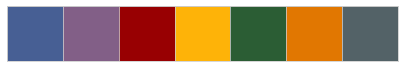

In [5]:
# import custom palette
import my_palette as mp

In [6]:
# read in actor dataset
df = pd.read_json('../data/capstone2_ds.json')

In [7]:
# observe dimensionality of dataset
df.shape

(11693, 28)

In [8]:
# separate data into features and target
X = df.drop('actor_value', axis=1)
y = df['actor_value']

In [9]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

First, I will get a base model without tuning any of the default hyperparameters.

In [10]:
def get_rfr_model(features, target, trials=None, iteration=None, params={}):
    """Return RF regressor model with option to modify hyperparameters"""
    # check if params need to be extracted from trials object
    if trials:
        # check if params need to be called by iteration number in trials object
        if iteration:
            params = trials.trials[iteration - 1]['result']['params']
        # extract params from best estimator of trials object
        else:
            params = trials.best_trial['result']['params']
    # instantiate regressor
    model = RandomForestRegressor(**params, random_state=27, n_jobs=-1)
        
    model.fit(features, target)
    
    return model

In [11]:
def get_params(features, target, trials=None, iteration=None, params={}):
    """Return only the hyperparameters of interest from an instantiated regressor"""
    model = get_rfr_model(
        features, target, trials=trials, iteration=iteration, params=params)
    series = pd.Series(
        model.get_params(), name='model_params').drop(
        ['bootstrap', 'criterion', 'max_leaf_nodes', 'min_impurity_decrease', 
         'min_impurity_split', 'min_weight_fraction_leaf', 'n_jobs', 
         'oob_score', 'random_state', 'verbose', 'warm_start'])
    
    return series

In [12]:
# get parameters for base model
get_params(X_train, y_train)

ccp_alpha               0
max_depth            None
max_features         auto
max_samples          None
min_samples_leaf        1
min_samples_split       2
n_estimators          100
Name: model_params, dtype: object

There are many hyperparameters to tune.<br>
I will break them into two groups.<br>
 - Tree Structure Based Complexity Moderation (Bias/Variance Trade-off)
     - max_depth: Controls how deep trees are allowed to grow 
         - Higher --> More Layers in Trees --> More Complexity
     - min_samples_leaf: Controls number of samples required to remain a leaf 
         - Lower --> Less Samples Needed To Remain a Leaf --> More Complexity
     - min_samples_split: Controls number of samples required to create new node 
         - Higher --> More Samples Needed To Split a Node --> Less Complexity
     - n_estimators: The number of trees in the forest
         - Higher --> More Trees --> More Complixity
 - Stochastic Based Complexity Moderation (Used to lower variance)
     - max_features: Fraction of features to use at each split
         - Lower --> Sample is Less Representative of Data --> Less Complexity
     - max_samples: Fraction of observations to use on each tree
         - Lower --> Sample is Less Representative of Data --> Less Complexity

I will use the mean absolute error (MAE) as my test statistic, as opposed to the root mean squared error (RMSE).<br>
The RMSE tends to increase more rapidly than the MAE, as the sample size increases.<br>
I will be using cross validation, extensively, throughout this analysis.<br>
Hense, RMSE may be problematic, when comparing errors between training and test performances.

In [13]:
def print_cv_mae(features, target, trials=None, iteration=None, params={}):
    """Print CV average mean absolute error and mean absolute error range"""
    # get fitted model
    model = get_rfr_model(
        features, target, trials=trials, iteration=iteration, params=params)
    # perform 10 fold cross validation
    cv_results = cross_val_score(model, features, target, 
                                 scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
    # convert scores to positive values
    results = cv_results * -1
    # get scores range
    results_range = (np.min(results), np.max(results))
    # get average score
    ave_result = np.mean(cv_results) * -1
        
    return f'Average MAE: ${ave_result:,.2f} \
    CV Range: (${results_range[0]:,.2f}, ${results_range[1]:,.2f})'

In [14]:
# get cross-validation results
print_cv_mae(X_train, y_train)

'Average MAE: $47,342,016.66     CV Range: ($41,617,244.06, $52,404,938.36)'

This error is nearly 10 million dollars less than what the base XGB model produced.

To get some perspective on this loss, I'll show the broad range of average revenues for the actors' movies.

In [15]:
# get average movie revenue and revenue range for all actors in training data
f'Average target: ${np.mean(y_train):,.2f} \
    Target Range: (${np.min(y_train):,.2f}, ${np.max(y_train):,.2f})'

'Average target: $138,069,846.47     Target Range: ($1.24, $7,377,967,622.48)'

With this range so wide, it is important to observe the standard deviation of the data, as well.

In [16]:
# get standard deviation of movie revenue for all actors in training data
f'Standard Deviation of Target: ${np.std(y_train):,.2f}'

'Standard Deviation of Target: $286,149,782.92'

Though the average error is large, it is well within one standard deviation of the target values.

I will create some residual plots, now.

In [17]:
# get base model
rfr_base = get_rfr_model(X_train, y_train)
rfr_base

RandomForestRegressor(n_jobs=-1, random_state=27)

In [18]:
def plot_predictions(features, target, model):
    """Return plot of observed target vs. predictions"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.scatterplot(y_test, model.predict(X_test), color=mp.colors(1))
    sns.regplot(y_test, model.predict(X_test), color=mp.colors(6), scatter=False)
    
    plt.xlabel('Observed')
    plt.ylabel('Predicted')
    
    plt.title("Ground Truth vs Predicted")

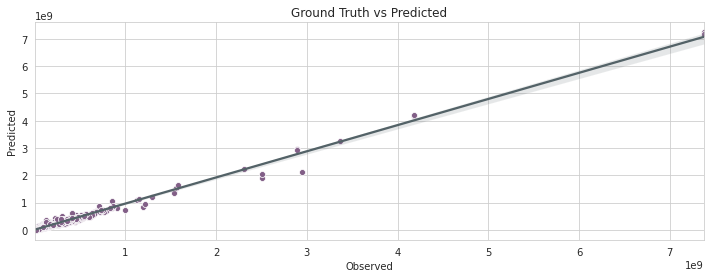

In [19]:
# plot observed target vs. predictions for out of the box rfr model
plot_predictions(X_train, y_train, rfr_base)

The extreme errors appear smaller than they were when using the base XGB model.

In [20]:
def plot_residuals(features, target, model):
    """Return plot of predictions vs.residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)

    sns.residplot(
        model.predict(X_test), y_test, lowess=True, scatter_kws={'s':10}, 
        color=mp.colors(2), line_kws={'linewidth':3})
    
    plt.xlabel('Predicted Actor Value')
    plt.ylabel('Residuals')
    
    plt.title("Predicted vs Residuals")

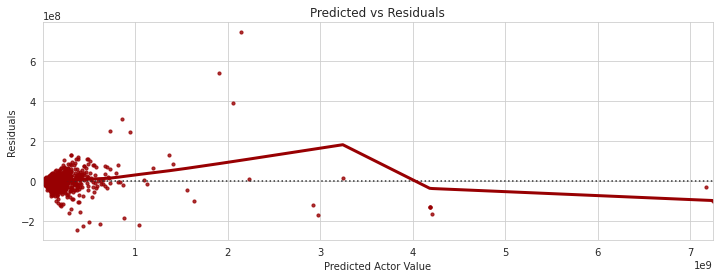

In [21]:
# plot predictions vs. residuals for out of the box rfr model
plot_residuals(X_train, y_train, rfr_base)

Unlike with the XGB model, there is clearly heteroscedasticity with respect to the residuals.

In [22]:
def plot_residual_distribution(features, target, model):
    """Return plot of distribution of residuals"""
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, test_size=0.2, random_state=27)
        
    sns.distplot(
        (y_test - model.predict(X_test)), bins=300, rug=True, axlabel='Residuals', 
        color=mp.colors(4))

    plt.ylabel('Frequency')

    plt.title('Distribution of Residuals')

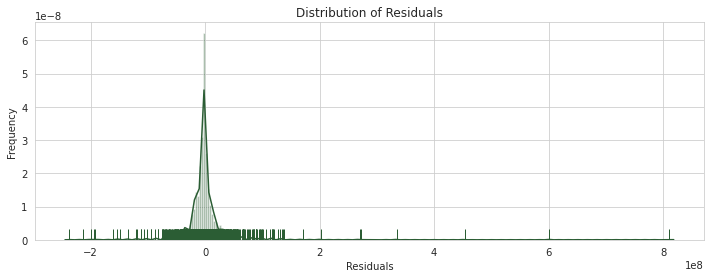

In [23]:
# plot residuals distribution for out of the box rfr model
plot_residual_distribution(X_train, y_train, rfr_base)

Like those of the XGB model, the distribution of residuals appers fairly normal.<br>
The one extreme outlier that was seen in the XGB model is not found here.

I will take a look at the feature importance for the predictions

In [24]:
def plot_feature_importance(features, model):
    """Plots the predictors by importance to model"""
    # create DataFrame of importances
    importance_df = pd.DataFrame(
        [model.feature_importances_], 
        index=['importance'], 
        columns=features.columns).transpose().sort_values('importance', ascending=False)
    # set grid
    fig, axes = plt.subplots(nrows=1, figsize=(12, 8))
    # set y range
    y_range = list(range(importance_df.shape[0]))
    
    plt.subplot(1, 1, 1)
    sns.barplot(importance_df['importance'], y_range, 
                orient='h', color=mp.colors(1))
    
    plt.yticks(y_range, importance_df.index.to_list())
    plt.xlabel('Feature Importance', fontsize=15);
    plt.ylabel('Feature', fontsize=15)
    
    plt.title('Feature Importance for Predictions', fontsize=15);
    
    return importance_df

,importance
runtime,0.321970
vote_count,0.229257
release_date,0.193197
budget,0.095282
popularity,0.049485
vote_average,0.022901
age,0.018259
war,0.008483
order,0.007613
adventure,0.007238


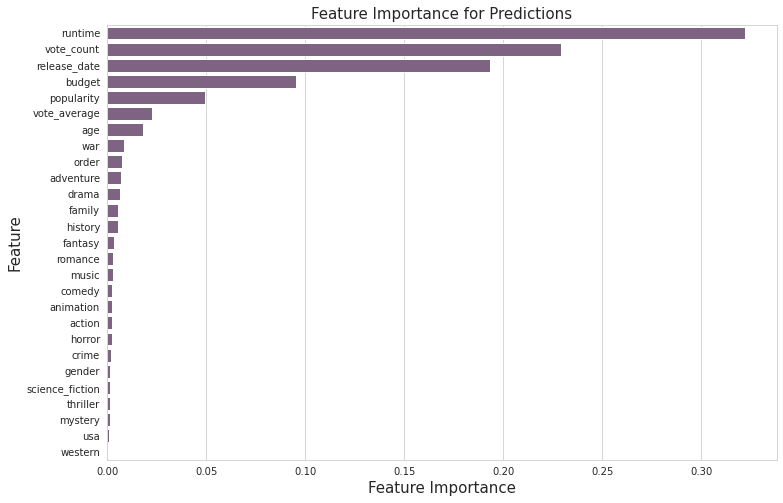

In [25]:
# get feature importance for model predictions
plot_feature_importance(X_train, rfr_base)

While the budget was the most important feature for the XGB predictions, runtime has taken the lead with the RF model.

I will perform an informed (Bayesian) search technique to find the best hyperparameters.<br>
This method has advantages over a brute force grid search, which tries all combinations of hyperparameters.<br>
It is closer to a random grid search, except the choices of parameters are based on the results of previous choices.

 > **BAYESIAN HYPERPARAMETER SEARCH**

My strategy will be to march through the hyperparameters, adding them one by one to the search.<br>
I will be looking for the best range of the current hyperparameter to keep, before progressing to the next one.<br>
This will help to reduce the number of possible local minima that the model may fall into along the search.<br>
It will reduce search time, as well, as some parameters are additive in computation time, as their ranges expand.<br>
Hense, I will be applying appropriate upper limits to those values during the search.

As hyperparameters are added, the optimal ranges for previous ones may change.<br>
I will be monitoring these needs along the way, making appropriate adjustments when necessary.<br>
I will plot cross validated results over a range of values to highlight the trade off between accuracy and overfitting.

The first hyperparameter to lock down is the number of estimators (trees) to have in the forest.<br>
This value should be set high to start, as the training accuracy will be directly affected by this choice.<br>
As more trees have a higher computational cost, I want to only add what my system can handle in a reasonable time.<br>
Tuning the rest of the hyperparameters will be an exercise in the mitigation of the high variance due to the many trees.

I have a dual goal of minimizing both the test error and the degree of overfitting.<br>
I will create a custom loss function that will guide the optimization procedure to a model that fulfills both goals.<br>
This will ensure that the final model is both accurate and generalizable.

The hybrid loss will be the sum of the test loss with the difference between the test loss and the training loss.

$Hybrid Loss=Test Error + Overfit Error$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$= Test Loss + (Test Loss - Training Loss)$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$= 2 * Test Loss - Training Loss$

In [26]:
def plot_hyperparameters(features, target, grid):
    """Plots CV results over range of one hyperparameter"""
    # instantiate model
    model = RandomForestRegressor(random_state=27, n_jobs=-1)
    # get scores from 10 fold CV over hyperparameter range
    gs_cv = GridSearchCV(model, grid, cv=10, n_jobs=-1, scoring='neg_mean_absolute_error', 
                         return_train_score=True, verbose=2).fit(features, target)
    # extract scores to DataFrame
    gs_df = pd.DataFrame(gs_cv.cv_results_)
    # separate scores and convert them to proper sign
    train_df = gs_df.loc[:, 'split0_train_score':'split9_train_score'].multiply(-1)
    test_df = gs_df.loc[:, 'split0_test_score':'split9_test_score'].multiply(-1)
    
    # get scores stats for plotting
    test_scores_mean = np.mean(test_df, axis=1)
    test_scores_std = np.std(test_df, axis=1)
    train_scores_mean = np.mean(train_df, axis=1)
    train_scores_std = np.std(train_df, axis=1)
    hybrid_scores_mean = 2 * test_scores_mean - train_scores_mean
    hybrid_scores_std = 2 * test_scores_std - train_scores_std
    
    # plot errors over range for variable hyperparameter
    var_param = {k:v for (k, v) in grid.items() if len(v) > 1}
    for param, param_lst in var_param.items():
        # plot hybrid scores
        sns.lineplot(x=param_lst, y=hybrid_scores_mean, label="Hybrid Score", lw=2)
        plt.fill_between(param_lst, hybrid_scores_mean - hybrid_scores_std,
                         hybrid_scores_mean + hybrid_scores_std, alpha=0.2, lw=2)
        # plot test scores
        sns.lineplot(x=param_lst, y=test_scores_mean, label="Test Score", lw=2)
        plt.fill_between(param_lst, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.2, lw=2)
        # plot training scores
        sns.lineplot(x=param_lst, y=train_scores_mean, label="Training Score", lw=2)
        plt.fill_between(param_lst, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.2, lw=2)
        
        plt.xlabel(param, fontsize=15)  
        plt.ylabel("MAE", fontsize=15)

        plt.legend(bbox_to_anchor=(1.2, 0.5), loc=5, fontsize='large')
        plt.title('Hyperparameters vs. Losses', fontsize=15)

 > **n_estimators**

I will start with tuning the number of trees.<br>
Recall, the default value is 100.

In [27]:
# create parameter search grid for range of number of trees
param_grid = {
    'n_estimators': [int(y) for y in [5, 10]] + [
        int(x) for x in np.linspace(50, 200, num=4)]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

n_estimators [5, 10, 50, 100, 150, 200]


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:   15.9s remaining:    5.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   20.7s finished


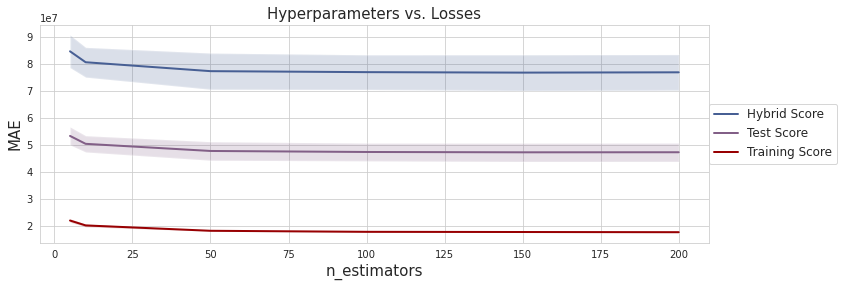

In [28]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, param_grid)

The effect of adding trees to the RF model is not as drastic as what was observed with XGB.<br>
RF uses fully grown trees, starting with a high variance and as low of a bias as possible.<br>
The method cannot reduce bias, but reduces the high variance by averaging the trees grown on random data subsampling.<br>
Though not observable here, the RF should have a lower variance compared to a fully grown individual decision tree.

With XGB, each tree is a weak learner with low variance and high bias.<br>
The trees are built in succession, with the next tree improving on the errors of the previous one.<br>
The main effect of this approach is the reduction of bias.<br>
This explains the observation that adding trees to the XGB model reduces the error through the reduction of the bias.

I am using the results from Scikit Learn's Cross Validate module to supply the metrics needed to construct a hybrid loss.<br>
The module returns both the test and training scores from a 10 fold cross-validation on the training data.<br>
I will observe the ratio of average training loss to average test loss over each fold to get a sense of overfitting.<br>
The hybrid loss will be the metric that is being optimized during the search for the best estimators for each batch of trials.

In [29]:
def objective(params, features, target):
    """Returns CV results for RFR regression"""
    # instantiate RFR Regressor
    rfr = RandomForestRegressor(n_jobs=-1, **params, random_state=27)
    # enable iteration marker to be GLOBAL variable
    global global_iterations
    # update marker
    global_iterations += 1
    # get all scores from 10 fold cross-validation
    cv_results = cross_validate(rfr, features, target, cv=10, n_jobs=-1, 
                                scoring='neg_mean_absolute_error', return_train_score=True)
    # convert scores to positive error
    train_mae = cv_results['train_score'] * -1
    test_mae = cv_results['test_score'] * -1    
    # get average scores from 10 fold cross-validation
    average_train_mae = np.mean(train_mae)
    average_test_mae = np.mean(test_mae)
    # define hybid loss
    hybrid_loss = 2 * average_test_mae - average_train_mae
    # get ratio of training score to test score
    tt_ratio = np.mean(np.divide(train_mae, test_mae))

    return {
        'trial': global_trials, 
        'batch': global_batches, 
        'iteration': global_iterations, 
        'loss': hybrid_loss, 
        'training_scores': average_train_mae, 
        'test_scores': average_test_mae,
        'scores_ratio': tt_ratio, 
        'params': params, 
        'status': STATUS_OK
    }

The optimization search will be callable for a maximum of 10 batches with a default of 100 fits for each batch.<br>
Early stopping will be called if the loss function has not improved over a full batch from the best value of the previous batch.

In [30]:
def run_trial_batches(features, target, hp_space, trials, batch_size=100, max_batches=10):
    """Runs informed search trials in batches with a cap on the number of batches"""
    # enable trial marker to be GLOBAL variable (allows continuation of existing trial)
    global global_trials
    global_trials +=1
    # check for newly initialized trials object
    if not trials.losses():
        # initialize best loss and number of iterations for new trials object
        last_best = 0
        last_iters = 0
    else:
        # initialize best loss and number of iterations from imported trials object
        last_best = trials.best_trial['result']['loss']
        last_iters = len(trials.losses())
    # initialize best loss for batch
    new_best = 0
    # initialize early stop flag
    early_stop = 'GO!'
    # run optimization search over all batches
    for batch in range(max_batches):
        # check for early stop
        if early_stop == 'GO!':
            # enable batch marker to be GLOBAL variable
            global global_batches
            # update trials batch counter
            global_batches += 1
            # set iterations argument for maximum evaluations parameter of fmin function
            n_iters = batch_size * (batch + 1) + last_iters
            # use partial function to enable selection of trials data
            fmin_objective = partial(objective, features=features, target=target)
            # run one batch
            fmin(fn=fmin_objective, space=hp_space, max_evals=n_iters, trials=trials, 
                 algo=tpe.suggest, rstate=np.random.RandomState(27))
            # save updated results to M.2 (stores most recent trials object)
            pickle.dump(trials, open('rfr_trials.pkl', 'wb'))
            # capture current optimal loss
            new_best = trials.best_trial['result']['loss']
            # check that batch optimized
            if last_best == new_best:
                early_stop = 'STOP!'
            last_best = new_best

Befor I start the search, I want to get a trials object for the base model for easy comparison.<br>
The default for the number of trees is 100.

 > **rfr_trials_0**

In [31]:
# instantiate trials object for RF Regressor optimization
rfr_trials_0 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [32]:
# create informed search space  
hp_space = {
    'n_estimators': ho_scope.int(hp.uniform('n_estimators', 100, 100.1))
}
# call optimization function
fmin_objective = partial(objective, features=X_train, target=y_train)
fmin(fn=fmin_objective, space=hp_space, max_evals=1, trials=rfr_trials_0, 
     algo=tpe.suggest, rstate=np.random.RandomState(27))
# save trials object
pickle.dump(rfr_trials_0, open('./rfr_trials/rfr_trials_0.pkl', 'wb'))

100%|██████████| 1/1 [00:04<00:00,  4.13s/trial, best loss: 76987755.64370468]


I will be attempting to minimize the base model hybrid loss of 76,987,755.64.<br>
This value is almost 15 milllion more than what was observed with XGB.

In [33]:
# get base metrics
base_training_loss = rfr_trials_0.best_trial['result']['training_scores']
base_test_loss = rfr_trials_0.best_trial['result']['test_scores']
f'The base test loss is ${base_test_loss:,.2f}. \
The base overfit ratio is {base_training_loss / base_test_loss:,.2f}'

'The base test loss is $47,342,016.66. The base overfit ratio is 0.37'

Breaking apart the hybrid loss, I can see that the MAE is nearly 10 million dollars less than that of the XGB model.<br>
This supports the low bias assumption of the RF model that was explained, earlier.<br>
The training to test scores ratio is 54% less, though.<br>
This shows the high variance that the RF models innately have, compared to the XGB models.

I will explore the first hyperparameter by setting the range from the default values up to a value of 200 trees.

 > **rfr_trials_1**

In [34]:
# instantiate trials object for RF Regressor optimization
rfr_trials_1 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [35]:
# create informed search space  
hp_space = {
    'n_estimators': ho_scope.int(hp.uniform('n_estimators', 100, 200))
}
# call optimization function
run_trial_batches(X_train, y_train, hp_space, rfr_trials_1, 50)
# save trials object
pickle.dump(rfr_trials_1, open('./rfr_trials/rfr_trials_1.pkl', 'wb'))

100%|██████████| 100/100 [04:58<00:00,  2.99s/trial, best loss: 76803516.31631559]


During the XGB trials, I set my trials batch size to the default of 100 models.<br>
The XGB library is several times faster than the Scikit Learn option.<br>
So, I am setting my trials batch size to 50 for the RF analysis.<br>
Even with setting the batch size to be half of that of the XGB trials, the trials take at least twice as long to run.<br>
This sets the early stopping to a lower threshold for the RF search.<br>
This is one of the advantages of using the XGB library, as more models can be evaluated in the same amount of time.

In [36]:
def plot_param_search(trials):
    """Plot iterations of optimization search for hyperparmeters"""
    # establish figure height (each hyperparameter + one optimization plot)
    num_subplots = len(trials.idxs.keys()) + 1
    fig_height = num_subplots * 4
    # establish subplots
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot parameters of optimization run
    count = 1
    for key in trials.idxs:
        plt.subplot(num_subplots, 1, count)
        
        # get number of trials in run
        n_iters = len(trials.losses())
        # get iteration of optimal hybrid loss
        best_iter = trials.best_trial['tid'] + 1        
        # get value for hyperparameter of best model
        best_val = trials.argmin[key]
        # get list of hyperparameter values
        vals_lst = trials.vals[key]
        
        # adjust values for data type
        if key in ['min_samples_leaf', 'min_samples_split', 'max_depth', 'n_estimators']:
            best_val = int(best_val)
            vals_lst = list(map(int, vals_lst))
        else:
            best_val = round(best_val, 6)
            
        # plot hyperparameters for optimization run
        plt.plot(range(1, len(trials.results) + 1), vals_lst, 
                 marker='o', color=mp.colors(4), alpha=0.8)        
        # mark off optimal hyperparameter value
        plt.hlines(best_val, n_iters * -0.05, n_iters * 1.05, linestyles = '--', 
                   label='Optimal \n' + str(key) + ': \n' + '{:,}'.format(best_val), 
                   colors=mp.colors(2))
        # mark iteration of optimal hybrid loss at hyperparameter value
        plt.plot(best_iter, best_val, marker='*', ms=15, color=mp.colors(2))
        count += 1
        
        plt.ylabel(key, fontsize=18)
        
        plt.legend(bbox_to_anchor=(1.31, 0.5), loc=5, fontsize='x-large')

    plt.subplot(num_subplots, 1, count)
    
    # get optimal hybrid loss value
    best_hybrid_loss = trials.best_trial['result']['loss']
    # get optimal test loss value
    best_test_loss = np.min([v['test_scores'] for v in trials.results])
    # get optimal training loss value
    best_training_loss = np.min([v['training_scores'] for v in trials.results])
    # set lower limit of plot
    y_min = np.min([best_hybrid_loss, best_test_loss, best_training_loss])
    
    # get largest hybrid loss value
    worst_hybrid_loss = np.max(trials.losses())
    # get largest test loss value
    worst_test_loss = np.max([v['test_scores'] for v in trials.results])
    # get largest training loss value
    worst_training_loss = np.max([v['training_scores'] for v in trials.results])
    # set upper limit of plot
    y_max = np.max([worst_hybrid_loss, worst_test_loss, worst_training_loss])
    
    # set y limits
    plt.ylim(y_min * 0.9, y_max * 1.1)
    
    # plot losses for optimization run
    sns.lineplot(x=range(1, n_iters + 1), 
                 y=trials.losses(), 
                 marker='o', label='Hybrid Loss')
    sns.lineplot(x=range(1, n_iters + 1), 
                 y=[v['test_scores'] for v in trials.results], 
                 marker='o', label='Test Loss')
    sns.lineplot(x=range(1, n_iters + 1), 
                 y=[v['training_scores'] for v in trials.results], 
                 marker='o', label='Training Loss')
    
    # mark off best hybrid loss
    plt.hlines(best_hybrid_loss, n_iters * -0.05, n_iters * 1.05, linestyles = '--', 
               colors='k')
    # mark iteration of optimal hybrid loss
    plt.plot(best_iter, best_hybrid_loss, marker='*', ms=15, color='k', 
             label='Hybrid Error: \n' + '${:,.2f}'.format(best_hybrid_loss))
    
    # get training and test loss for model with best hybrid loss
    corresponding_test_loss = trials.best_trial['result']['test_scores']
    corresponding_training_loss = trials.best_trial['result']['training_scores']
    # put training and test loss values for model with best hybrid loss in legend
    plt.plot(0, 0, linewidth=0, label='Test Error: \n' + '${:,.2f}'.format(
                   corresponding_test_loss))
    plt.plot(0, 0, linewidth=0, label='Training Error: \n' + '${:,.2f}'.format(
                   corresponding_training_loss))

    plt.xlabel('Iteration (Best Iteration: ' + str(best_iter) + ')', fontsize=15)
    plt.ylabel('MAE', fontsize=18)
    
    plt.legend(bbox_to_anchor=(1.33, 0.5), loc=5, fontsize='x-large', 
               title='Best Iteration', title_fontsize='x-large')
    plt.suptitle('Hyperparameter Optimization Sequence', y=0.93, fontsize=23)

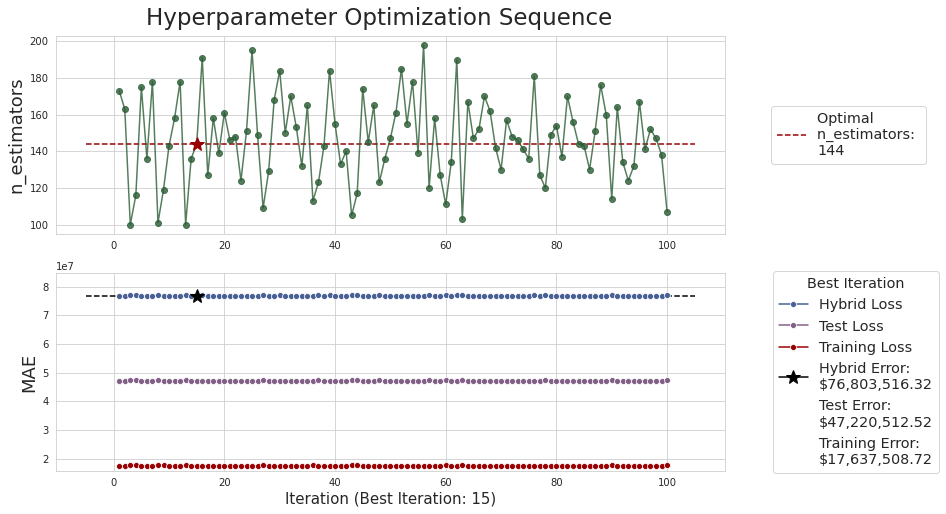

In [37]:
# plot informed search history
plot_param_search(rfr_trials_1)

The informed search does not appear to be constrained by the range of allowable values for the number of trees.

The three losses being tracked will always appear in this order.<br>
The goals are to lower the test loss while bringing the training loss nearer to it.<br>
Individual improvements with respect to one of these goals will be seen in a lower hybrid loss.

In [38]:
def make_trials_df(trials):
    """Makes a DataFrame from results dict of objective function sorted by loss"""
    # convert dict to DataFrame
    trials_df = pd.DataFrame(trials.results)
    # extract nested parameter dicts to separate DataFrame
    params_df = pd.DataFrame(trials_df['params'].to_list())
    # combine DataFrames, clean up, and order by best losses
    trials_df = trials_df.drop(
        ['params', 'status'], axis=1).join(
        params_df).sort_values('loss', ascending=True)
    
    return trials_df

In [39]:
# get results DataFrame
trials_1_df = make_trials_df(rfr_trials_1)
trials_1_df.head(10)

,trial,batch,iteration,loss,training_scores,test_scores,scores_ratio,n_estimators
14,1,1,15,7.680352e+07,1.763751e+07,4.722051e+07,0.375624,144
83,1,2,84,7.680352e+07,1.763751e+07,4.722051e+07,0.375624,144
71,1,2,72,7.680774e+07,1.762871e+07,4.721823e+07,0.375461,148
21,1,1,22,7.680774e+07,1.762871e+07,4.721823e+07,0.375461,148
25,1,1,26,7.680842e+07,1.762680e+07,4.721761e+07,0.375421,149
78,1,2,79,7.680842e+07,1.762680e+07,4.721761e+07,0.375421,149
45,1,1,46,7.680911e+07,1.764088e+07,4.722499e+07,0.375657,145
72,1,2,73,7.681252e+07,1.763999e+07,4.722625e+07,0.375629,146
20,1,1,21,7.681252e+07,1.763999e+07,4.722625e+07,0.375629,146
30,1,1,31,7.681314e+07,1.762459e+07,4.721886e+07,0.375384,150


The losses have been reduced slightly.<br>
The variance appears unchanged.

I will look at the distribution of values chosen for the hyperparameter during the search.

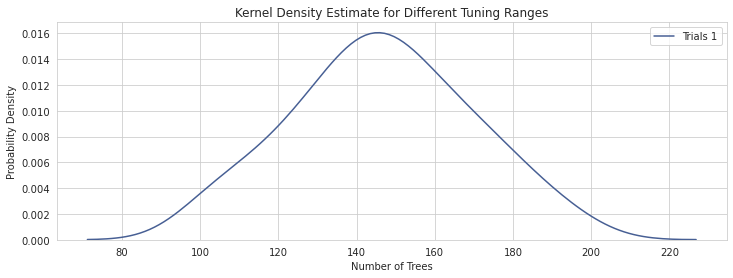

In [40]:
# plot kernel density estimates for number of trees
sns.kdeplot(trials_1_df['n_estimators'], label='Trials 1')

plt.xlabel('Number of Trees')
plt.ylabel('Probability Density')

plt.title('Kernel Density Estimate for Different Tuning Ranges');

The chosen range is supporting a balanced distribution of hyperparameters.

I will observe the losses over the range of hyperparameters to notice the effects of different choices.

In [41]:
def plot_one_param(trials, param, param_min=None, param_max=None):
    """Plots MAEs vs. one hyperparameter with the option to limit the range"""
    df = make_trials_df(trials)
    # check to see if range needs to be altered
    if (param_min and param_max):
        df = df[(df[param] > param_min) & (df[param] < param_max)]        
    # plot hyperparameters for optimization run
    sns.regplot(x=param, y='loss', data=df, 
        scatter_kws={"s": 10}, label='Hybrid Loss')
    sns.regplot(x=param, y='test_scores', data=df, 
        scatter_kws={"s": 10}, label='Test Loss')
    sns.regplot(x=param, y='training_scores', data=df, 
        scatter_kws={"s": 10}, label='Training Loss')

    plt.xlabel(param, fontsize=14)
    plt.ylabel('MAE', fontsize=14)
    
    plt.legend(bbox_to_anchor=(1.25, 0.5), loc=5, fontsize='x-large')

In [42]:
def plot_maes(trials):
    """Plots mean absolute errors for all hyperparameters"""
    # establish figure height
    num_subplots = len(trials.idxs)
    fig_height = num_subplots * 4
    # establish subplots
    fig, axes = plt.subplots(nrows=num_subplots, figsize=(12, fig_height))
    # plot hyperparameters of optimization run
    count = 1
    # get all hyperparameters in trials object
    for key in trials.idxs:
        plt.subplot(num_subplots, 1, count)
        # call hyperparameter plotting function
        plot_one_param(trials, key)
        
        plt.xlabel(key, fontsize=14)
        plt.ylabel('MAE', fontsize=14)
        
        plt.legend(bbox_to_anchor=(1.25, 0.5), loc=5, fontsize='x-large')
        count += 1
        
    plt.suptitle('Hyperparameter Informed Search Results', y=0.93, fontsize=23);

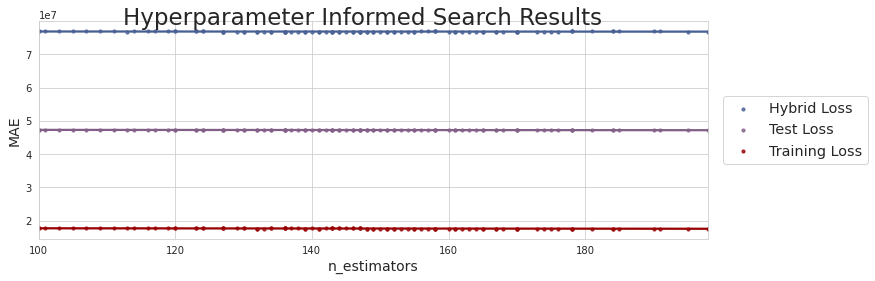

In [43]:
# plot hyperparameters vs. mean absolute errors
plot_maes(rfr_trials_1)

The models do not seem to be effected by the number of trees, at this point.<br>
I will not increase this range until necessary to avoid additional computational cost for no optimization benefit.

I will hold this number of trees and move on to the next hyperparameter.

 > **max_depth**

I will continue the search, focusing on the depth of the trees<br>
Recall, the default value is None.

In [44]:
# get best hyperparameters from last trials
best_params = rfr_trials_1.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'max_depth': [int(x) for x in np.linspace(1, 20, num=11)],
    'n_estimators': [best_params['n_estimators']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

max_depth [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
n_estimators [144]


Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:   33.8s finished


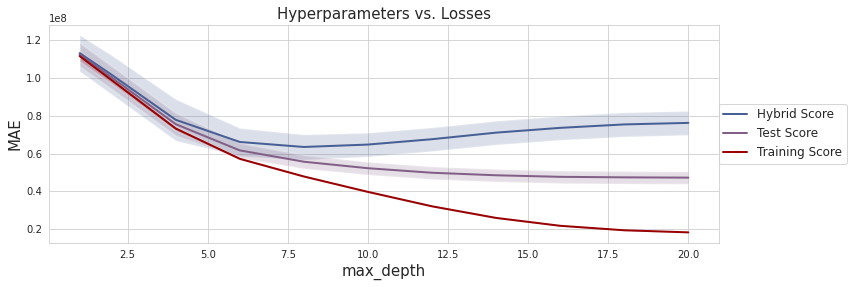

In [45]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, param_grid)

The overfitting is very restrained for the small hyperparameter values.<br>
I will set the lower bound with values of 6 and the upper bound to be 10 layers deep.

 > **rfr_trials_2**

In [46]:
# instantiate trials object for RF Regressor optimization
rfr_trials_2 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [47]:
# create informed search space  
hp_space = {
    'max_depth': ho_scope.int(hp.uniform('max_depth', 6, 11)),
    'n_estimators': ho_scope.int(hp.uniform('n_estimators', 100, 200))
}
# call optimization function
run_trial_batches(X_train, y_train, hp_space, rfr_trials_2, 50)
# save trials object
pickle.dump(rfr_trials_2, open('./rfr_trials/rfr_trials_2.pkl', 'wb'))

100%|██████████| 100/100 [02:47<00:00,  1.67s/trial, best loss: 63337859.38084174]


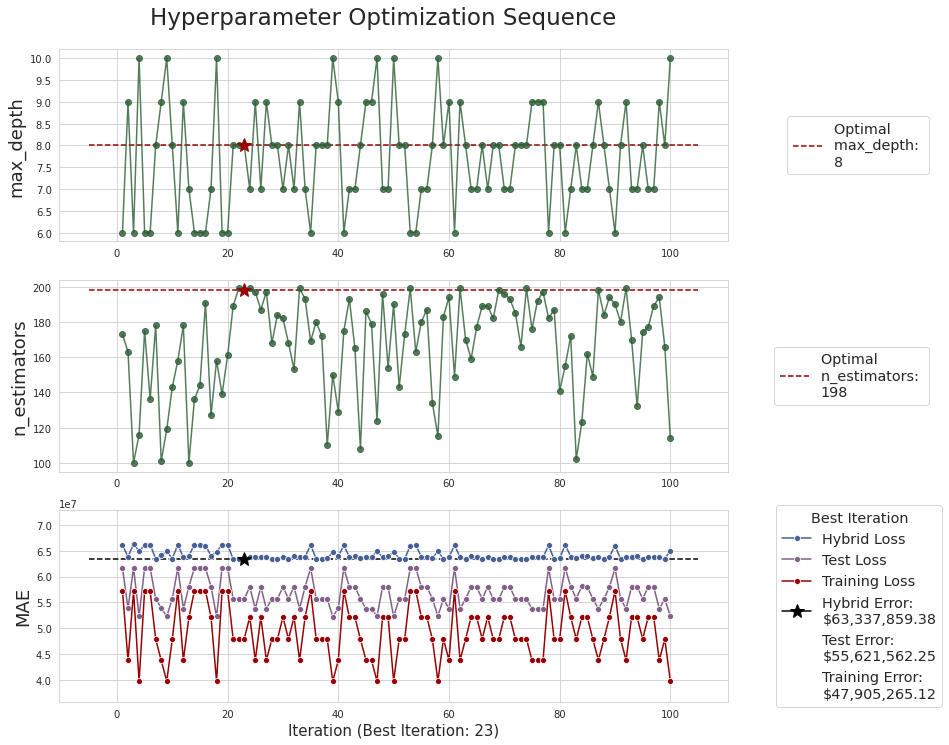

In [48]:
# plot informed search history
plot_param_search(rfr_trials_2)

The maximum depth values seem to be wide enough to allow exploration.<br>
The models may need more trees, though.

In [49]:
# get results DataFrame
trials_2_df = make_trials_df(rfr_trials_2)
trials_2_df.head(10)

,trial,batch,iteration,loss,training_scores,test_scores,scores_ratio,max_depth,n_estimators
68,1,2,69,6.333786e+07,4.790527e+07,5.562156e+07,0.864994,8,198
22,1,1,23,6.333786e+07,4.790527e+07,5.562156e+07,0.864994,8,198
21,1,1,22,6.335965e+07,4.789938e+07,5.562952e+07,0.864769,8,199
73,1,2,74,6.335965e+07,4.789938e+07,5.562952e+07,0.864769,8,199
78,1,2,79,6.339581e+07,4.788506e+07,5.564044e+07,0.864228,8,187
71,1,2,72,6.342249e+07,4.787725e+07,5.564987e+07,0.863941,8,185
65,1,2,66,6.342372e+07,4.789143e+07,5.565758e+07,0.864077,8,189
20,1,1,21,6.342372e+07,4.789143e+07,5.565758e+07,0.864077,8,189
58,1,2,59,6.342486e+07,4.788426e+07,5.565456e+07,0.864019,8,183
62,1,2,63,6.342721e+07,4.787554e+07,5.565137e+07,0.863869,8,170


The maximum depth hyperparamter has a large effect in lowering the variance.<br>
This can be observed by the overfit ratio, which is now on par with those of the XGB models.<br>
Although decreasing, the loss scores are still higher than those of the XGB models.<br>
A value of 8 for the maximum depth is preferred by the best performing models.<br>
I will set this as the final value to narrow the search space.<br>
This will free up time to explore combinations for other hyperparameters.

Now, I'll check on the distribution of values tried by the search.

In [50]:
def plot_kde(trials_dict):
    """Plot range of hyperparameters for each trial given"""
    # create empty dict to hold DataFrames of trials parameters
    df_dict = {}
    # fill dict with each DataFrame
    for trial, num in trials_dict.items():
        # create default dict to sort values of hyperparameters
        param_dict = defaultdict(list)
        # extract iterations
        for d in trial.miscs:
            # sort values from iteration
            for key, val in d['vals'].items():
                param_dict[key].append(val[0])
            # store sorted hyperparameter values from each trial in DataFrame
            param_df = pd.DataFrame(param_dict)
        # add DataFrame to dict
        df_dict[num] = param_df
    # get maximum number of hyperparameters to establish subplots
    n_rows = max([len(x.columns) for x in df_dict.values()])
    fig_height = n_rows * 4
    fig, axes = plt.subplots(nrows=n_rows, figsize=(12, fig_height))
    # create empty dict to map hyperparameters to axes numbers
    axes_dict = {}
    ax_num = -1
    # expand my color palette by looping it three times
    my_palette = ['xkcd:' + c for c in mp.my_colors] * 3
    # sort hyperparameters out of DataFrames
    for num, df in df_dict.items():
        # get list of hyperparameters from DataFrame
        cols_lst = list(df.columns)
        # go through hyperparameters and plot
        for param in cols_lst:        
            # build axes mapper
            if param not in list(axes_dict.keys()):
                ax_num += 1
                axes_dict[param] = ax_num
            # plot kernel density estimate for hyperparameter
            g = sns.kdeplot(df[param], label=num, color=my_palette[num - 1], 
                        ax=axes[axes_dict[param]])
            g.set_xlabel(param, fontsize=15)
            g.set_ylabel('Probability Density', fontsize=15)

    plt.suptitle('Kernel Density Estimates for Different Tuning Ranges', fontsize=15)
    plt.subplots_adjust(top=0.95)

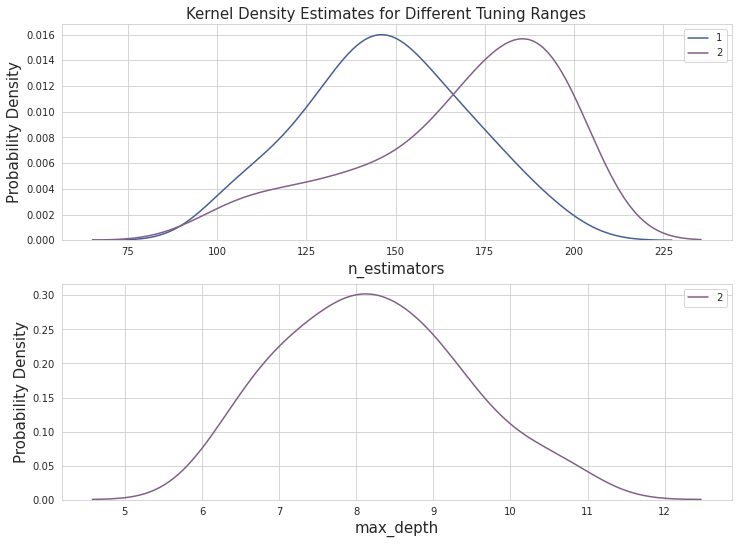

In [51]:
# assemble desired trial runs
_dict = {rfr_trials_1: 1, 
         rfr_trials_2: 2
        }
# plot the results, so far
plot_kde(_dict)

The distribution of the number of trees is shifting toward the upper bound.

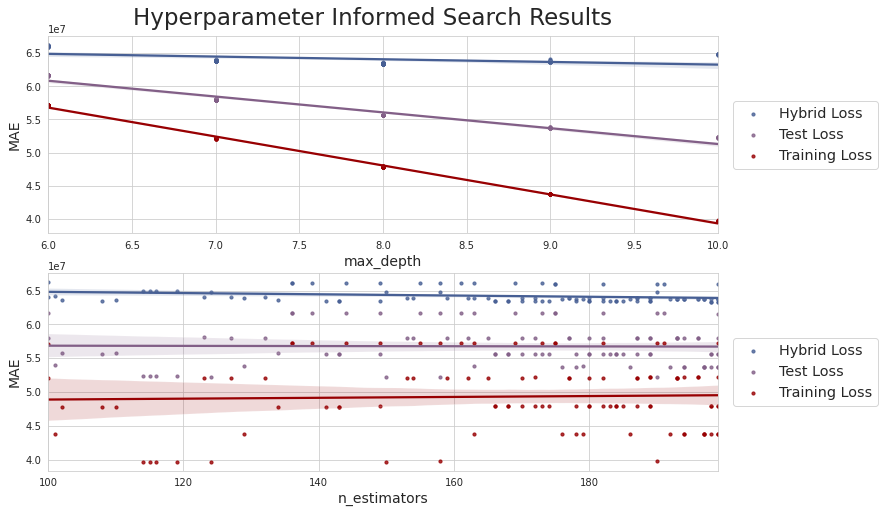

In [52]:
# plot hyperparameters vs. mean absolute errors
plot_maes(rfr_trials_2)

The hybrid loss lines are fairly horizontal.<br>
The maximum depth hyperparameters tends to overfit with higher values.<br>
The opposite is true of the number of trees.

I will shift the range for the number of trees to higher values between 150 and 250 trees.

 > **rfr_trials_3**

In [53]:
# instantiate trials object for RF Regressor optimization
rfr_trials_3 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [54]:
# create informed search space  
hp_space = {
    'max_depth': ho_scope.int(hp.uniform('max_depth', 8, 8.01)),
    'n_estimators': ho_scope.int(hp.uniform('n_estimators', 150, 250))
}
# call optimization function
run_trial_batches(X_train, y_train, hp_space, rfr_trials_3, 50)
# save trials object
pickle.dump(rfr_trials_3, open('./rfr_trials/rfr_trials_3.pkl', 'wb'))

100%|██████████| 100/100 [03:17<00:00,  1.98s/trial, best loss: 63317767.8669339]


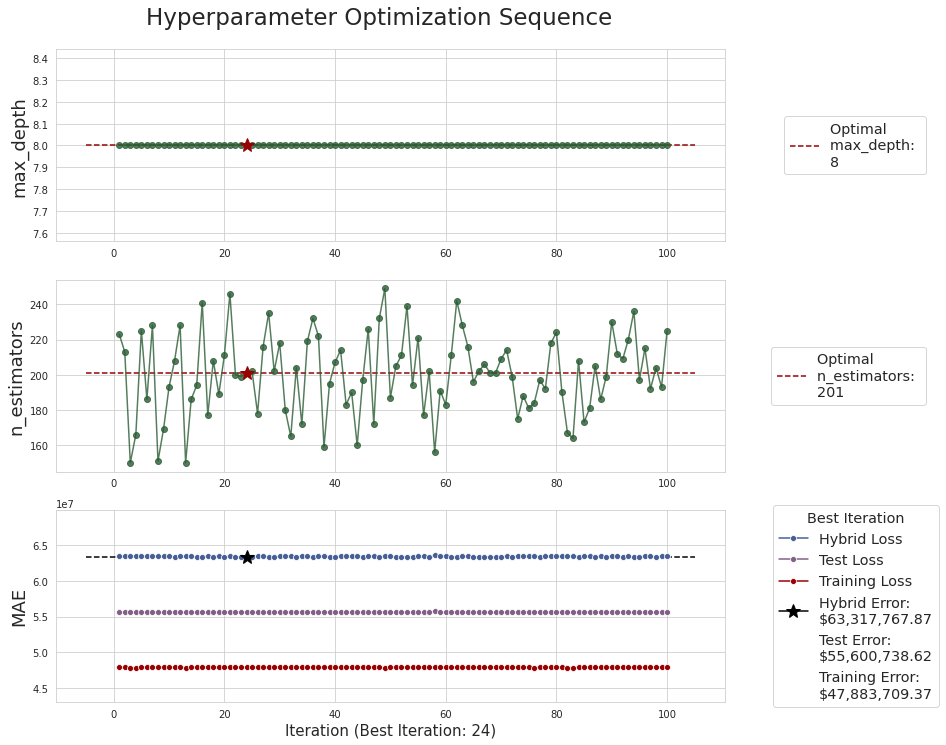

In [55]:
# plot informed search history
plot_param_search(rfr_trials_3)

The shifted range of the number of trees seems to give the search space more room to be explored.

In [56]:
# get results DataFrame
trials_3_df = make_trials_df(rfr_trials_3)
trials_3_df.head(10)

,trial,batch,iteration,loss,training_scores,test_scores,scores_ratio,max_depth,n_estimators
23,1,1,24,6.331777e+07,4.788371e+07,5.560074e+07,0.864902,8,201
67,1,2,68,6.331777e+07,4.788371e+07,5.560074e+07,0.864902,8,201
68,1,2,69,6.331777e+07,4.788371e+07,5.560074e+07,0.864902,8,201
28,1,1,29,6.331908e+07,4.787621e+07,5.559765e+07,0.864815,8,202
24,1,1,25,6.331908e+07,4.787621e+07,5.559765e+07,0.864815,8,202
56,1,2,57,6.331908e+07,4.787621e+07,5.559765e+07,0.864815,8,202
65,1,2,66,6.331908e+07,4.787621e+07,5.559765e+07,0.864815,8,202
86,1,2,87,6.333730e+07,4.789353e+07,5.561541e+07,0.864825,8,205
50,1,2,51,6.333730e+07,4.789353e+07,5.561541e+07,0.864825,8,205
21,1,1,22,6.334918e+07,4.788933e+07,5.561926e+07,0.864728,8,200


The metrics have only slightly improved.

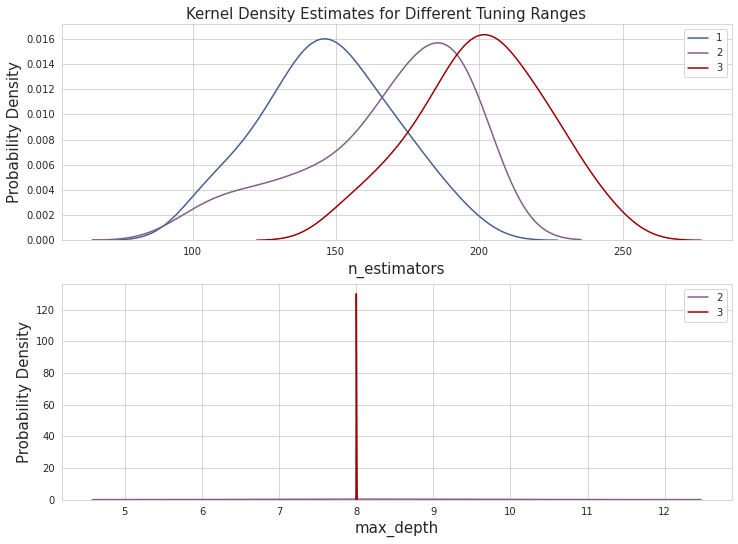

In [57]:
# assemble desired trial runs
_dict = {rfr_trials_1: 1, 
         rfr_trials_2: 2, 
         rfr_trials_3: 3
        }
# plot the results, so far
plot_kde(_dict)

The distribution of the number of trees is symmetric throughout the range.

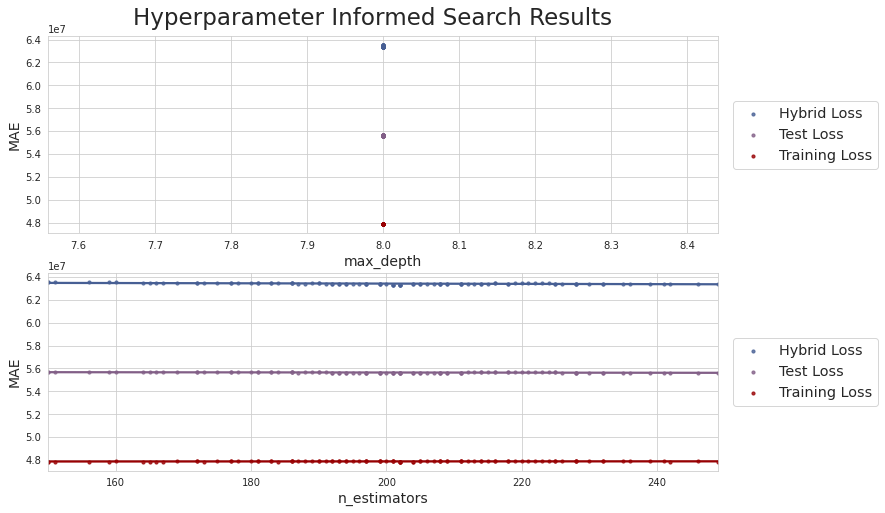

In [58]:
# plot hyperparameters vs. mean absolute errors
plot_maes(rfr_trials_3)

The losses are level within these hyperparameter ranges.<br>
I'll move on to the next hyperparameter, the minimum number of samples needed to split an inner node.<br>
The default value is 2.

 > **min_samples_split**

In [59]:
# get best hyperparameters from last trials
best_params = rfr_trials_3.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'max_depth': [best_params['max_depth']],
    'min_samples_split': [int(x) for x in np.linspace(2, 7, num=6)], 
    'n_estimators': [best_params['n_estimators']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

max_depth [8]
min_samples_split [2, 3, 4, 5, 6, 7]
n_estimators [201]


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:   17.3s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   21.9s finished


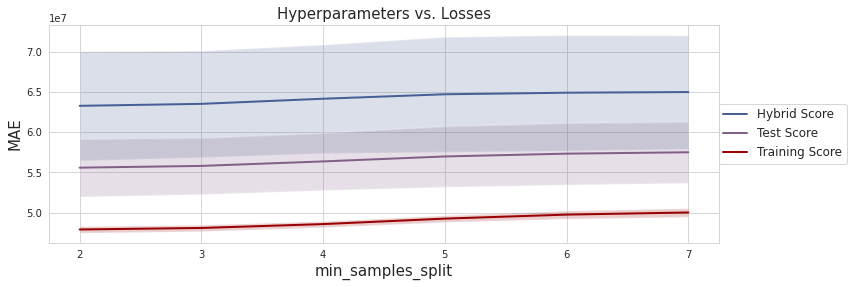

In [60]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, param_grid)

The default value appears to be the optimal one.<br>
I'll explore the next value and set the upper bound to be 3.

 > **rfr_trials_4**

In [61]:
# instantiate trials object for RF Regressor optimization
rfr_trials_4 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [62]:
# create informed search space  
hp_space = {
    'max_depth': ho_scope.int(hp.uniform('max_depth', 8, 8.01)),
    'min_samples_split': ho_scope.int(hp.uniform('min_samples_split', 2, 4)),
    'n_estimators': ho_scope.int(hp.uniform('n_estimators', 150, 250))
}
# call optimization function
run_trial_batches(X_train, y_train, hp_space, rfr_trials_4, 50)
# save trials object
pickle.dump(rfr_trials_4, open('./rfr_trials/rfr_trials_4.pkl', 'wb'))

100%|██████████| 100/100 [03:16<00:00,  1.97s/trial, best loss: 63317767.8669339]


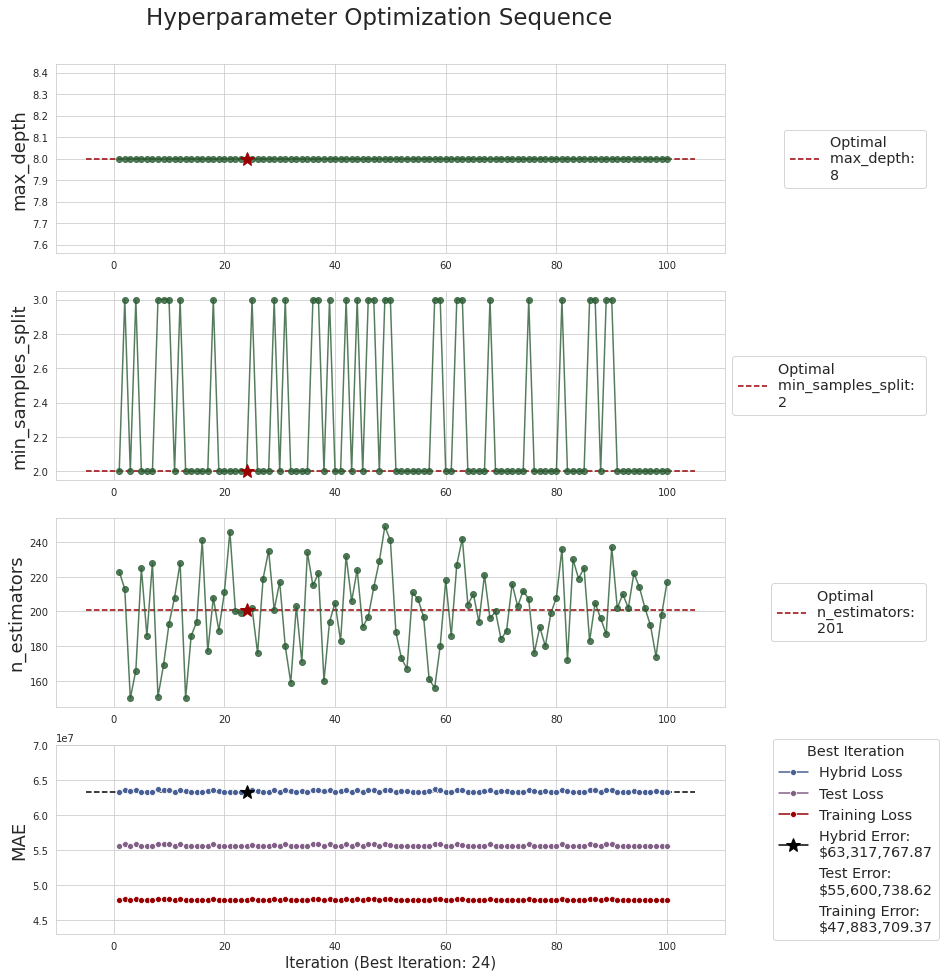

In [63]:
# plot informed search history
plot_param_search(rfr_trials_4)

In [64]:
# get results DataFrame
trials_4_df = make_trials_df(rfr_trials_4)
trials_4_df.head(10)

,trial,batch,iteration,loss,training_scores,test_scores,scores_ratio,max_depth,min_samples_split,n_estimators
23,1,1,24,6.331777e+07,4.788371e+07,5.560074e+07,0.864902,8,2,201
95,1,2,96,6.331908e+07,4.787621e+07,5.559765e+07,0.864815,8,2,202
92,1,2,93,6.331908e+07,4.787621e+07,5.559765e+07,0.864815,8,2,202
90,1,2,91,6.331908e+07,4.787621e+07,5.559765e+07,0.864815,8,2,202
39,1,1,40,6.333730e+07,4.789353e+07,5.561541e+07,0.864825,8,2,205
98,1,2,99,6.333786e+07,4.790527e+07,5.562156e+07,0.864994,8,2,198
21,1,1,22,6.334918e+07,4.788933e+07,5.561926e+07,0.864728,8,2,200
68,1,2,69,6.334918e+07,4.788933e+07,5.561926e+07,0.864728,8,2,200
63,1,2,64,6.335209e+07,4.788048e+07,5.561628e+07,0.864554,8,2,204
54,1,2,55,6.335343e+07,4.789165e+07,5.562254e+07,0.864645,8,2,207


Adjusting this hyperparameter has no effect on the results.

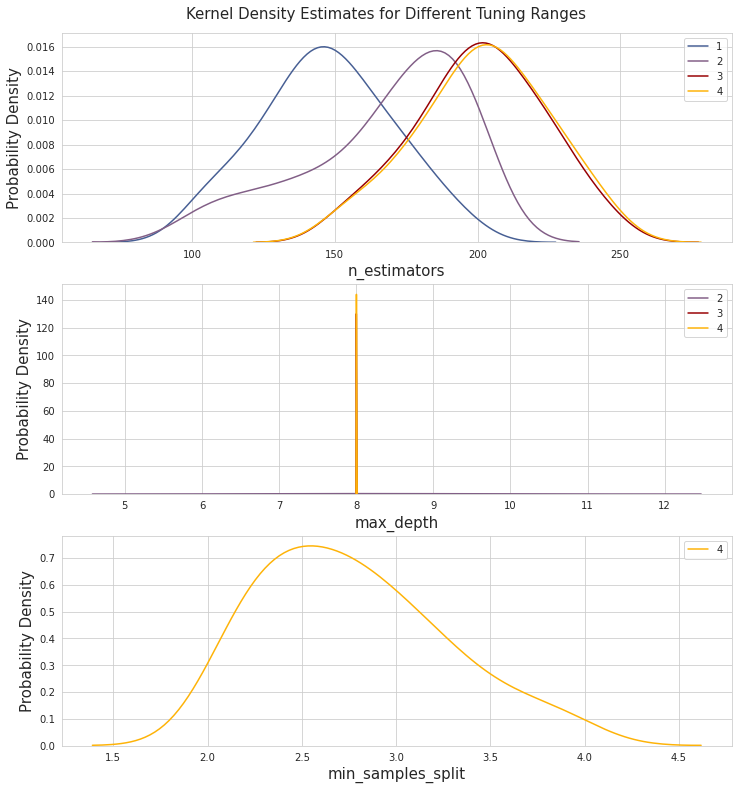

In [65]:
# assemble desired trial runs
_dict = {rfr_trials_1: 1, 
         rfr_trials_2: 2, 
         rfr_trials_3: 3, 
         rfr_trials_4: 4
        }
# plot the results, so far
plot_kde(_dict)

The search may be using its limited number of chances by exploring values for the number of samples needed for splits.

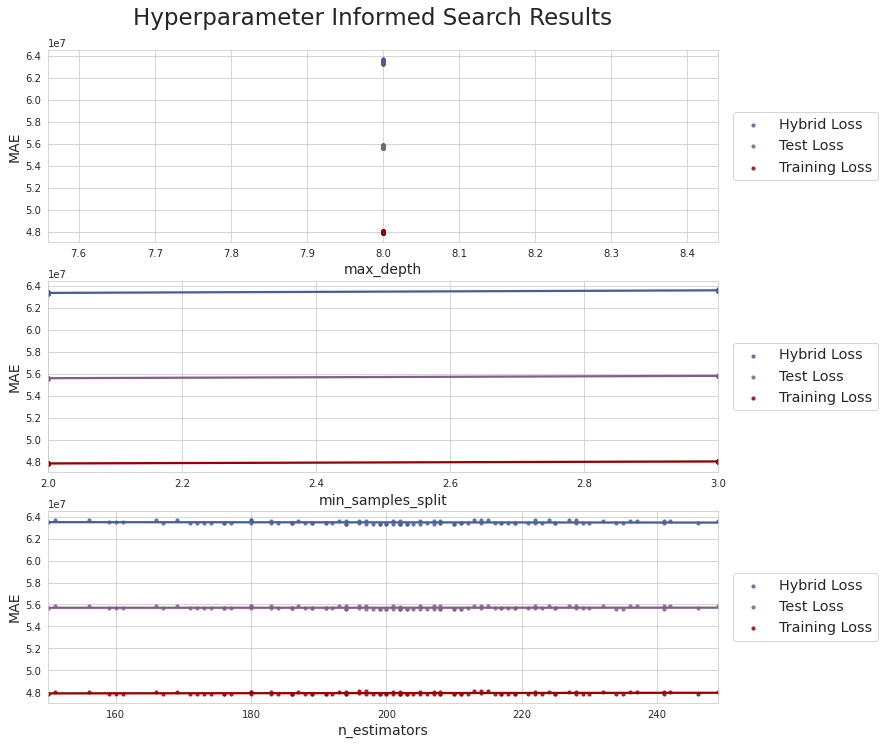

In [66]:
# plot hyperparameters vs. mean absolute errors
plot_maes(rfr_trials_4)

I will remove this hyperparameter from the search and leave it at the default value of 2.

The next hyperparameter to explore is the minimum number of samples needed to create a leaf.<br>
The default value is 1.

 > **min_samples_leaf**

In [67]:
# get best hyperparameters from last trials
best_params = rfr_trials_4.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'max_depth': [best_params['max_depth']],
    'min_samples_leaf': [int(x) for x in np.linspace(1, 6, num=6)], 
    'n_estimators': [best_params['n_estimators']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

max_depth [8]
min_samples_leaf [1, 2, 3, 4, 5, 6]
n_estimators [201]


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  60 | elapsed:   17.4s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   21.9s finished


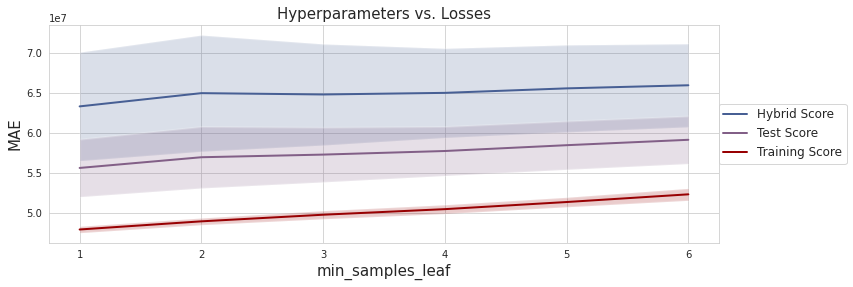

In [68]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, param_grid)

The default value is the best with this hyperparameter, as well.<br>
I will explore a bit higher, up to a value of 4, just to be sure that is correct.

 > **rfr_trials_5**

In [69]:
# instantiate trials object for RF Regressor optimization
rfr_trials_5 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [70]:
# create informed search space  
hp_space = {
    'max_depth': ho_scope.int(hp.uniform('max_depth', 8, 8.01)),
    'min_samples_leaf': ho_scope.int(hp.uniform('min_samples_leaf', 1, 5)),
    'n_estimators': ho_scope.int(hp.uniform('n_estimators', 150, 250))
}
# call optimization function
run_trial_batches(X_train, y_train, hp_space, rfr_trials_5, 50)
# save trials object
pickle.dump(rfr_trials_5, open('./rfr_trials/rfr_trials_5.pkl', 'wb'))

100%|██████████| 100/100 [03:17<00:00,  1.98s/trial, best loss: 63317767.8669339]


There is no change in the hybrid loss.

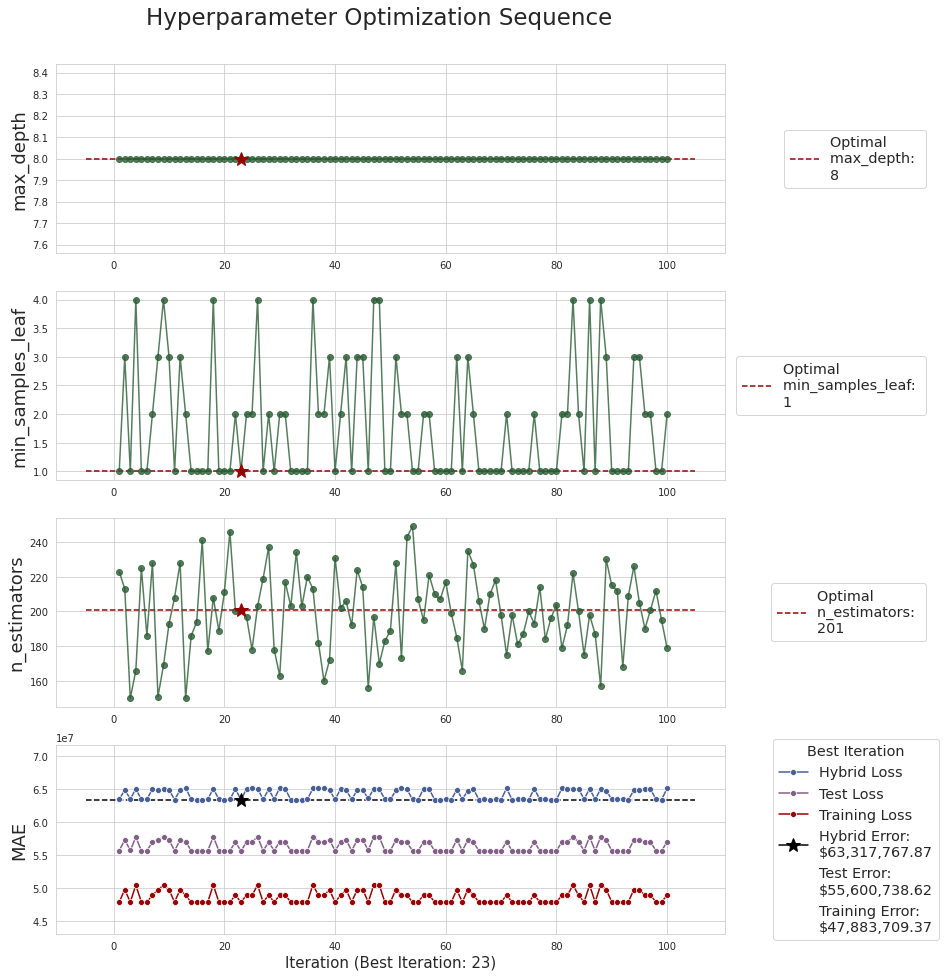

In [71]:
# plot informed search history
plot_param_search(rfr_trials_5)

In [72]:
# get results DataFrame
trials_5_df = make_trials_df(rfr_trials_5)
trials_5_df.head(10)

,trial,batch,iteration,loss,training_scores,test_scores,scores_ratio,max_depth,min_samples_leaf,n_estimators
22,1,1,23,6.331777e+07,4.788371e+07,5.560074e+07,0.864902,8,1,201
69,1,2,70,6.333786e+07,4.790527e+07,5.562156e+07,0.864994,8,1,198
71,1,2,72,6.333786e+07,4.790527e+07,5.562156e+07,0.864994,8,1,198
74,1,2,75,6.334918e+07,4.788933e+07,5.561926e+07,0.864728,8,1,200
79,1,2,80,6.335209e+07,4.788048e+07,5.561628e+07,0.864554,8,1,204
54,1,2,55,6.335343e+07,4.789165e+07,5.562254e+07,0.864645,8,1,207
58,1,2,59,6.335343e+07,4.789165e+07,5.562254e+07,0.864645,8,1,207
98,1,2,99,6.335747e+07,4.790906e+07,5.563326e+07,0.864847,8,1,195
60,1,2,61,6.335965e+07,4.789938e+07,5.562952e+07,0.864769,8,1,199
33,1,1,34,6.336106e+07,4.788582e+07,5.562344e+07,0.864544,8,1,203


All of the values are the same as leaving this hyperparameter at the default value, as well.

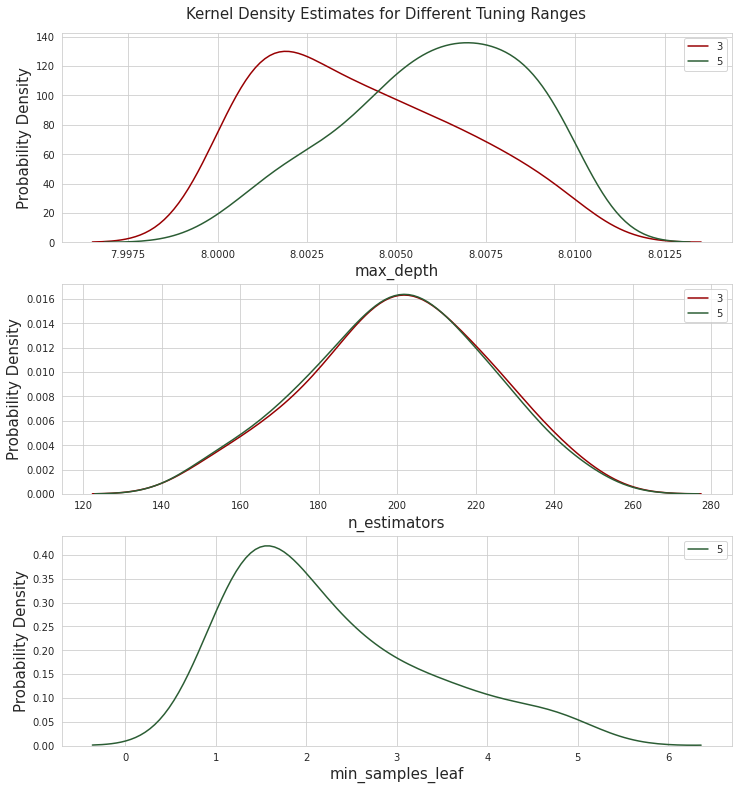

In [73]:
# assemble desired trial runs
_dict = {rfr_trials_3: 3, 
         rfr_trials_5: 5
        }
# plot the results, so far
plot_kde(_dict)

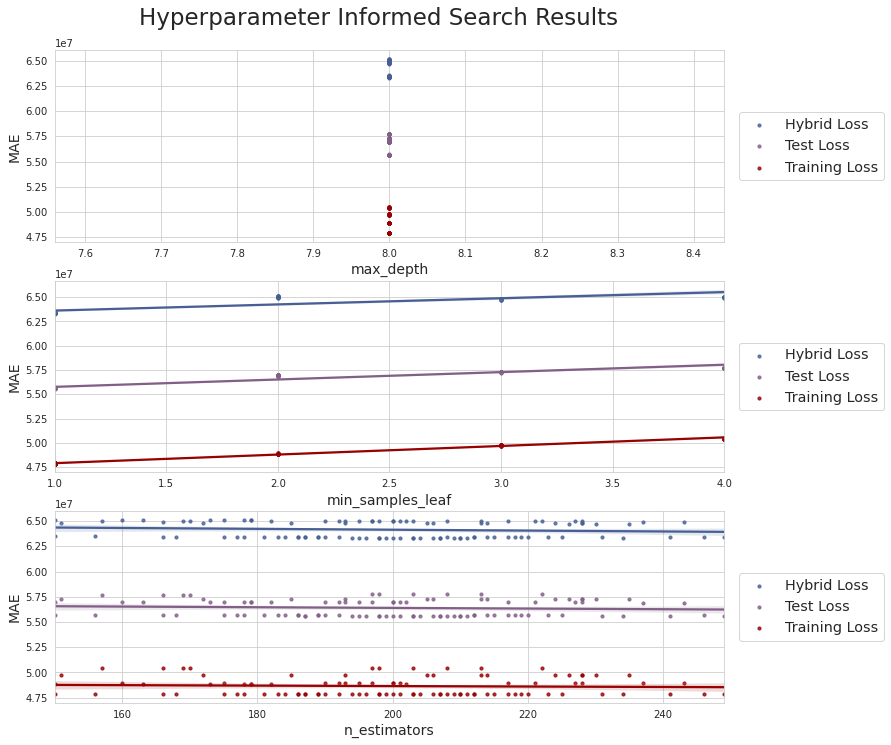

In [74]:
# plot hyperparameters vs. mean absolute errors
plot_maes(rfr_trials_5)

I will remove this hyperparameter from the search space.

Before I add the additional sampling hyperparameters, I want to observe the progress, so far.

In [75]:
def plot_metrics(trials_dict):
    """Plot loss metrics and ratio of training and test losses for best ensembles"""
    # establish subplots
    fig, axes = plt.subplots(nrows=2, figsize=(12, 9))
    # construct DataFrame
    df = join_losses(trials_dict)
    # plot loss metrics
    plt.subplot(2, 1, 1)
    sns.lineplot(x=df.index, y='loss', data=df, label='Hybrid Loss')
    sns.lineplot(x=df.index, y='test_scores', data=df, label='Test Loss')
    sns.lineplot(x=df.index, y='training_scores', data=df, label='Training Loss')
    
    plt.ylabel('MAE', fontsize=15)

    plt.legend(bbox_to_anchor=(1.2, 0.5), loc=5, fontsize='large')
    plt.title('Mean Absolute Errors for Best Ensamble of Each Trial')
    # plot training test loss ratio
    plt.subplot(2, 1, 2)
    sns.lineplot(x=df.index, y='scores_ratio', data=df)
    
    plt.xlabel('Trials', fontsize=15)
    plt.ylabel('Training to Test Loss Ratio', fontsize=15)

In [76]:
def join_losses(trials_dict):
    """Extracts losses and hyperparameters for best estimator of each trials object"""
    # specify columns to extract
    loss_cols = ['loss', 'training_scores', 'test_scores', 'scores_ratio']
    # instantiate empty DataFrame
    df = pd.DataFrame()
    # iterate through trials objects
    for key, value in trials_dict.items():
        # extract metrics
        loss_df = pd.DataFrame(
            key.best_trial['result'], index=[value], columns=loss_cols)
        # extract parameters for best estimator of each trial session
        params_df = pd.DataFrame(
            key.best_trial['result']['params'], index=[value])
        # put it all together
        trials_df = loss_df.join(params_df)
        df = pd.concat([df, trials_df])
        df.reset_index()
        
    return df

I am omitting the trials for the hyperparameters that I decided didn't need to be tuned.

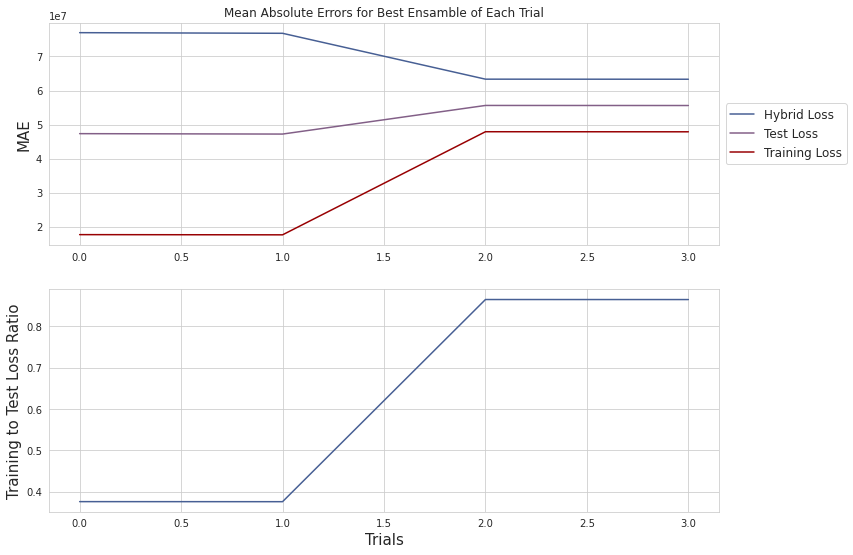

In [77]:
# assemble desired trial runs
_dict = {rfr_trials_0: 0, 
         rfr_trials_1: 1, 
         rfr_trials_2: 2, 
         rfr_trials_3: 3
        }
# plot the results, so far
plot_metrics(_dict)

The addition of the maximum depth of the trees at trials 2 was the only hyperparameter that needed to be tuned, so far.

I will move on to the stochastic hyperparameters.<br>
The next one to tune is the maximum proportion of observations to use to grow the trees.<br>
The default value is 1.

 > **max_samples**

In [78]:
# get best hyperparameters from last trials
best_params = rfr_trials_5.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'max_depth': [best_params['max_depth']],
    'max_samples': np.linspace(0.1, 1, 10),
    'n_estimators': [best_params['n_estimators']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

max_depth [8]
max_samples [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
n_estimators [201]


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   20.8s finished


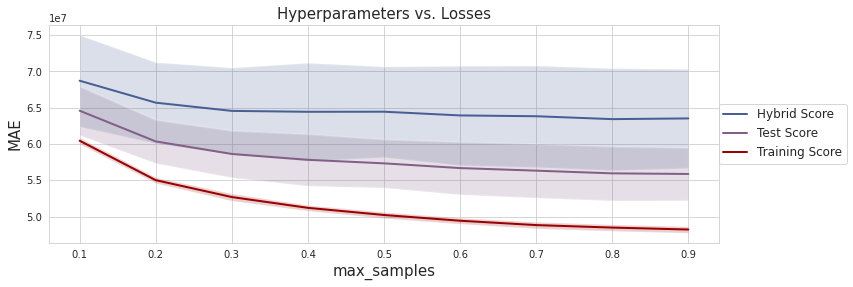

In [79]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, param_grid)

There doesn't appear to be any benefit to drawing less than half the number of samples to grow the trees.<br>
I will set the range to be above 0.5.

 > **rfr_trials_6**

In [80]:
# instantiate trials object for RF Regressor optimization
rfr_trials_6 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [81]:
# create informed search space  
hp_space = {
    'max_depth': ho_scope.int(hp.uniform('max_depth', 8, 8.01)),
    'max_samples': hp.uniform('max_samples', 0.5, 1),
    'n_estimators': ho_scope.int(hp.uniform('n_estimators', 150, 250))
}
# call optimization function
run_trial_batches(X_train, y_train, hp_space, rfr_trials_6, 50)
# save trials object
pickle.dump(rfr_trials_6, open('./rfr_trials/rfr_trials_6.pkl', 'wb'))

100%|██████████| 100/100 [03:07<00:00,  1.88s/trial, best loss: 63213160.79297561]


The hybrid loss has finally decreased, again.

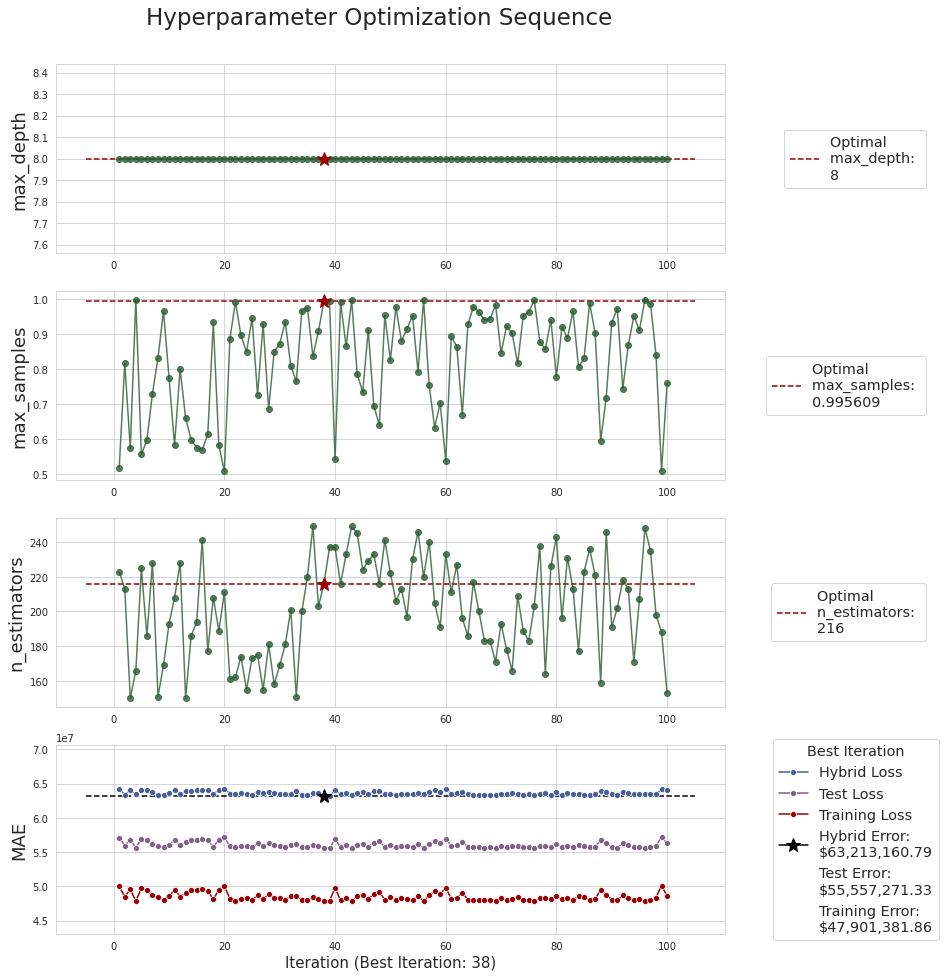

In [82]:
# plot informed search history
plot_param_search(rfr_trials_6)

The best number of samples to use was very close to all of the samples.

In [83]:
# get results DataFrame
trials_6_df = make_trials_df(rfr_trials_6)
trials_6_df.head(10)

,trial,batch,iteration,loss,training_scores,test_scores,scores_ratio,max_depth,max_samples,n_estimators
37,1,1,38,6.321316e+07,4.790138e+07,5.555727e+07,0.865880,8,0.995609,216
38,1,1,39,6.321625e+07,4.788891e+07,5.555258e+07,0.865763,8,0.995446,237
66,1,2,67,6.326586e+07,4.805534e+07,5.566060e+07,0.867223,8,0.941401,183
78,1,2,79,6.329457e+07,4.809382e+07,5.569419e+07,0.867340,8,0.941063,226
33,1,1,34,6.333224e+07,4.801738e+07,5.567481e+07,0.866209,8,0.967840,200
65,1,2,66,6.333537e+07,4.803057e+07,5.568297e+07,0.866369,8,0.964041,200
42,1,1,43,6.335026e+07,4.787132e+07,5.561079e+07,0.864463,8,0.997953,249
90,1,2,91,6.335095e+07,4.797763e+07,5.566429e+07,0.865687,8,0.973704,202
67,1,2,68,6.335272e+07,4.806994e+07,5.571133e+07,0.866573,8,0.943480,183
84,1,2,85,6.335383e+07,4.839830e+07,5.587606e+07,0.870062,8,0.832790,223


Both parts of the hybrid loss have been further optimized.

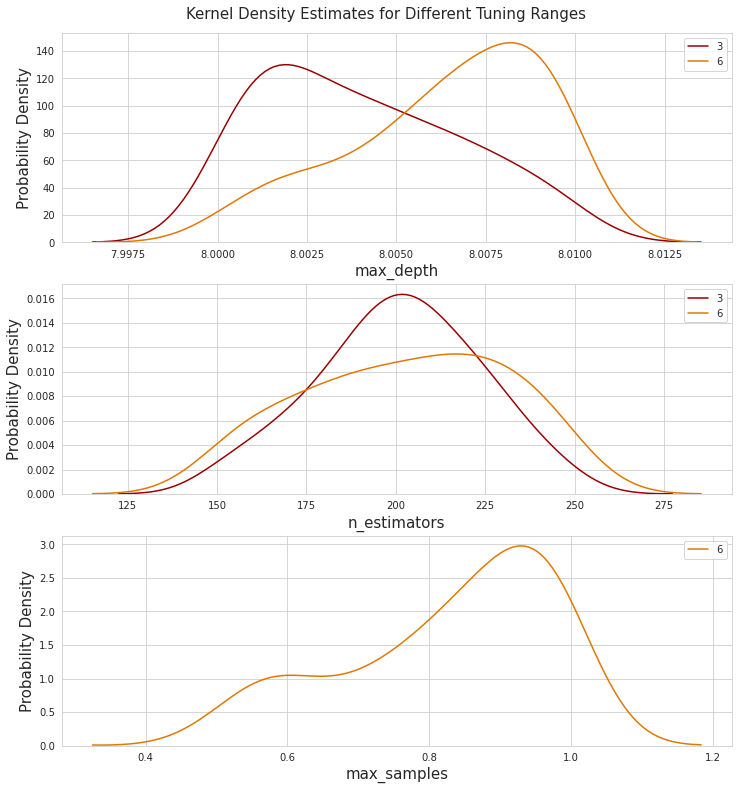

In [84]:
# assemble desired trial runs
_dict = {rfr_trials_3: 3, 
         rfr_trials_6: 6
        }
# plot the results, so far
plot_kde(_dict)

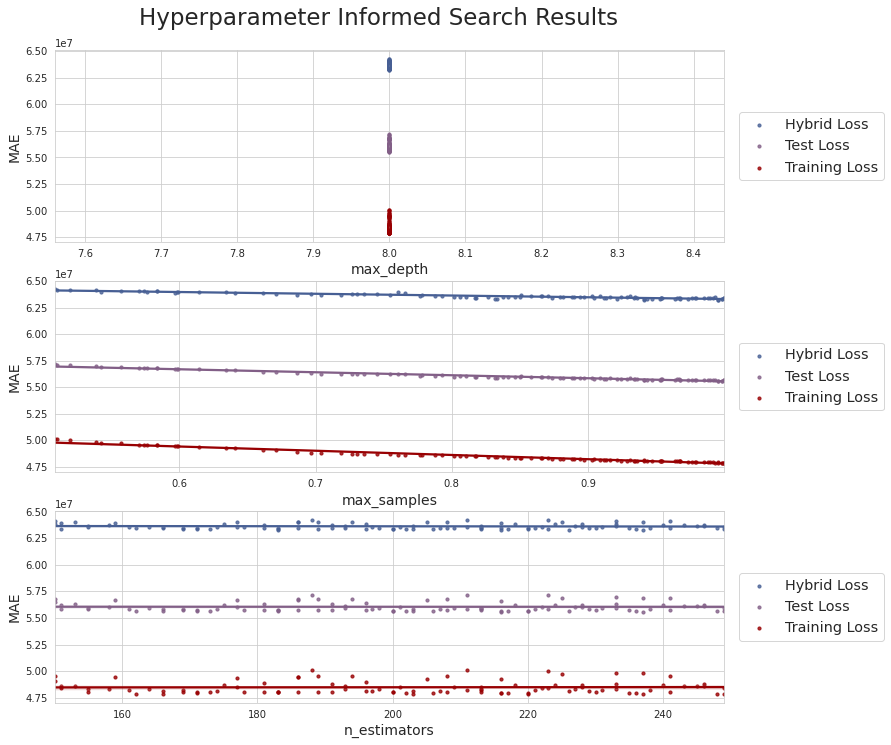

In [85]:
# plot hyperparameters vs. mean absolute errors
plot_maes(rfr_trials_6)

The RF optimization is rather uneventful, compared to the XGB analysis.

I will turn to the hyperparameter that controls the proportion of feature used to grow the trees.<br>
It has a default value of 1, also.

 > **max_features**

In [86]:
# get best hyperparameters from last trials
best_params = rfr_trials_6.best_trial['result']['params']
# create parameter search grid
param_grid = {
    'max_depth': [best_params['max_depth']],
    'max_features': np.linspace(0.1, 1, 10),
    'max_samples': [best_params['max_samples']],
    'n_estimators': [best_params['n_estimators']]
}
# show values
for param, param_lst in param_grid.items():
    print(param, param_lst)

max_depth [8]
max_features [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
max_samples [0.9956088975030613]
n_estimators [216]


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   22.9s finished


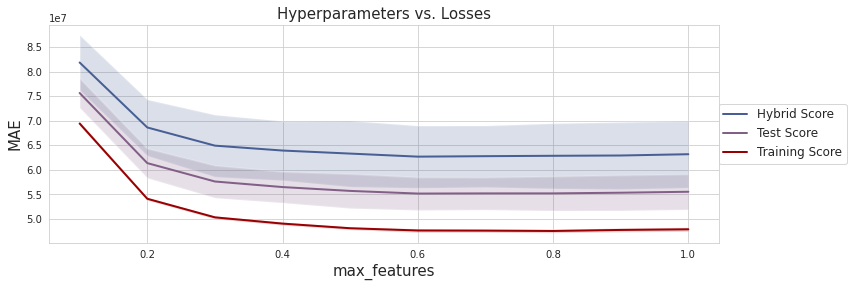

In [87]:
# plot cross validation results for hyperparameter range
plot_hyperparameters(X_train, y_train, param_grid)

The values above 60% of the features used seem to be in the best range.<br>
I will set the lower bound to be 0.6.

 > **rfr_trials_7**

In [88]:
# instantiate trials object for RF Regressor optimization
rfr_trials_7 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [89]:
# create informed search space  
hp_space = {
    'max_depth': ho_scope.int(hp.uniform('max_depth', 8, 8.01)),
    'max_features': hp.uniform('max_features', 0.6, 1),
    'max_samples': hp.uniform('max_samples', 0.5, 1),
    'n_estimators': ho_scope.int(hp.uniform('n_estimators', 150, 250))
}
# call optimization function
run_trial_batches(X_train, y_train, hp_space, rfr_trials_7, 50)
# save trials object
pickle.dump(rfr_trials_7, open('./rfr_trials/rfr_trials_7.pkl', 'wb'))

100%|██████████| 200/200 [02:13<00:00,  1.50trial/s, best loss: 62573938.10414039]


The hybrid loss has been improved.

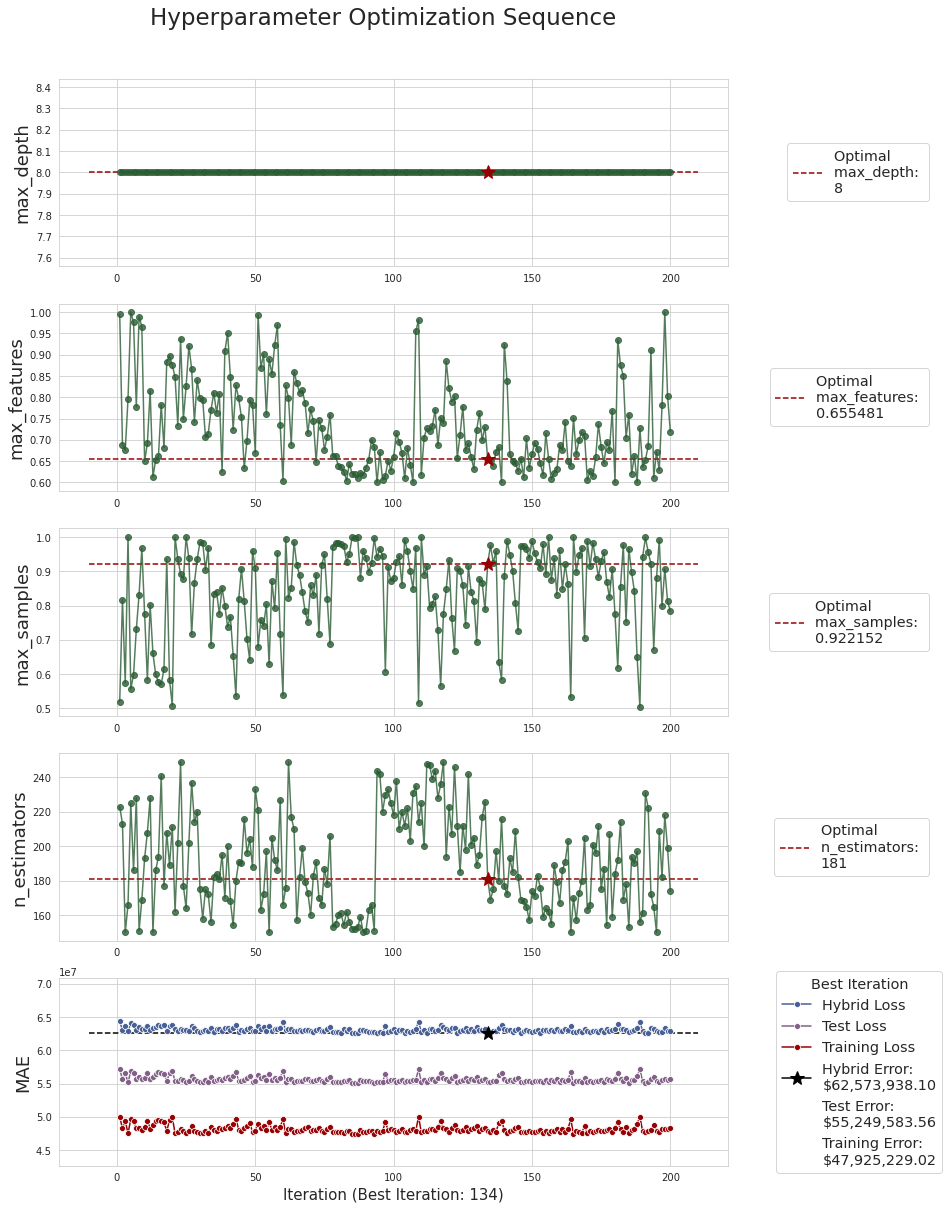

In [90]:
# plot informed search history
plot_param_search(rfr_trials_7)

Subsampling with a smaller number of features is more advantageous than subsampling on a smaller set of observations.

In [91]:
# get results DataFrame
trials_7_df = make_trials_df(rfr_trials_7)
trials_7_df.head(10)

,trial,batch,iteration,loss,training_scores,test_scores,scores_ratio,max_depth,max_features,max_samples,n_estimators
133,1,3,134,6.257394e+07,4.792523e+07,5.524958e+07,0.870706,8,0.655481,0.922152,181
122,1,3,123,6.257754e+07,4.800847e+07,5.529300e+07,0.871577,8,0.657607,0.908530,212
85,1,2,86,6.257945e+07,4.747043e+07,5.502494e+07,0.866018,8,0.619353,0.996338,152
134,1,3,135,6.258491e+07,4.779151e+07,5.518821e+07,0.869123,8,0.653635,0.975185,169
190,1,4,191,6.261894e+07,4.770433e+07,5.516163e+07,0.868261,8,0.653366,0.998583,231
111,1,3,112,6.262308e+07,4.784200e+07,5.523254e+07,0.869864,8,0.727605,0.914563,248
152,1,4,153,6.263716e+07,4.801512e+07,5.532614e+07,0.871138,8,0.644769,0.908288,176
95,1,2,96,6.263858e+07,4.784358e+07,5.524108e+07,0.869459,8,0.606031,0.944672,220
84,1,2,85,6.265031e+07,4.747453e+07,5.506242e+07,0.865383,8,0.620522,0.999189,152
103,1,3,104,6.265172e+07,4.770589e+07,5.517881e+07,0.868102,8,0.609776,0.991706,212


The overfitting ratio is close to the optimal one obtained with the XGB method.<br>
The losses are much worse, though.

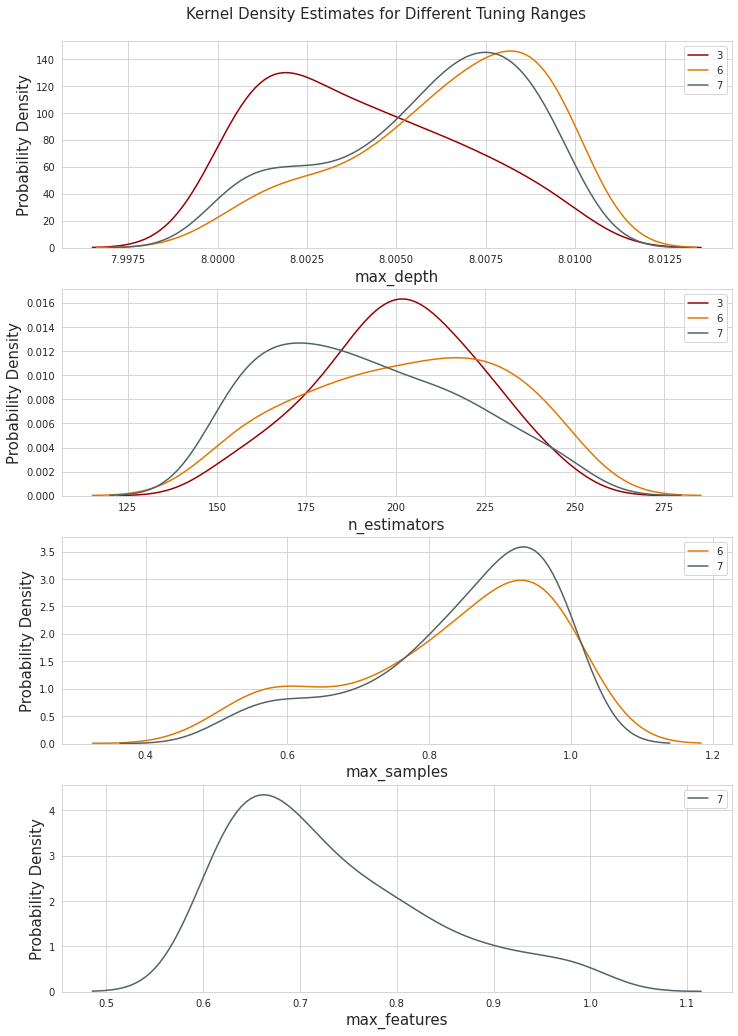

In [92]:
# assemble desired trial runs
_dict = {rfr_trials_3: 3, 
         rfr_trials_6: 6, 
         rfr_trials_7: 7
        }
# plot the results, so far
plot_kde(_dict)

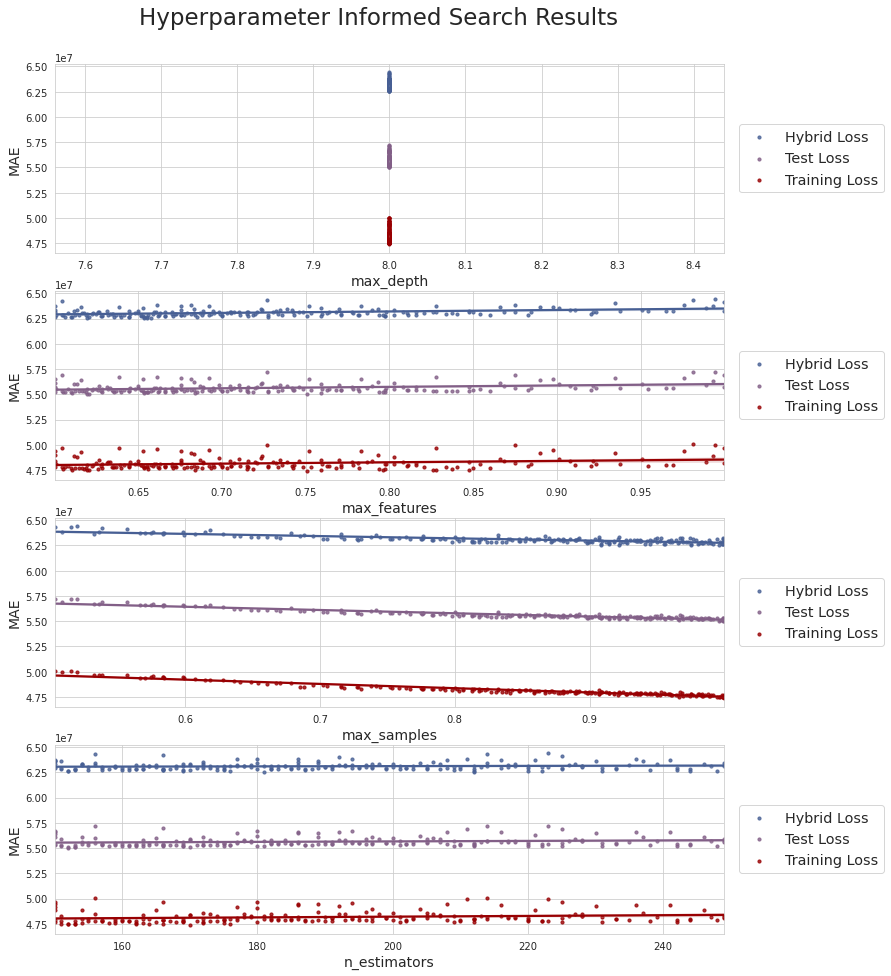

In [93]:
# plot hyperparameters vs. mean absolute errors
plot_maes(rfr_trials_7)

I'll pause to observe the journey, so far.

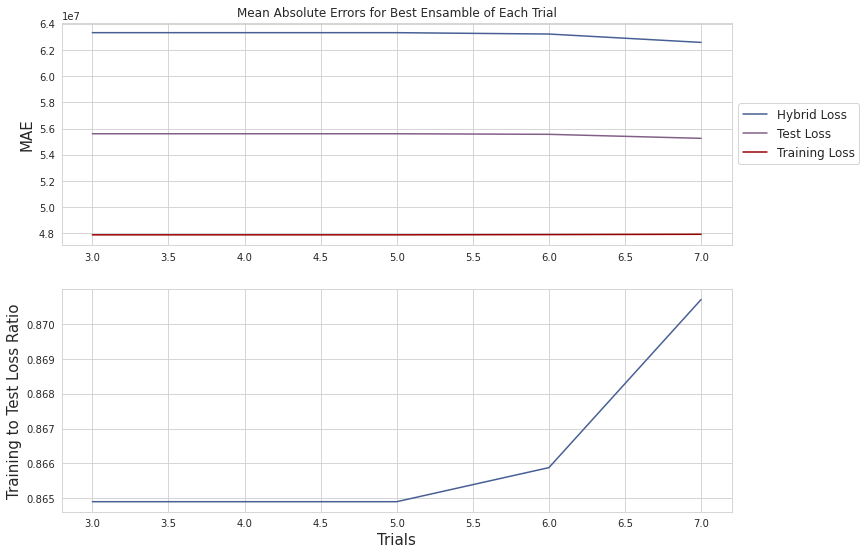

In [94]:
# assemble desired trial runs
_dict = {rfr_trials_3: 3, 
         rfr_trials_4: 4, 
         rfr_trials_5: 5, 
         rfr_trials_6: 6, 
         rfr_trials_7: 7
        }
# plot the results, so far
plot_metrics(_dict)

The test part of the hybrid error has really only been decreased through subsampling of the features.<br>
The scale of loss ratios is small.<br>
Not much improvement has been made to reduce the variance, after the maximum depth was modified in trials 2.

Now, I believe this is as far as I can traditionally tune the hyperparameters, but I have one more card to play.<br>
I'm going to cherry pick the ranges of hyperparameters from trials 7, the one.<br>
This will squeze the search into a tight area I know is fruitful to see if I can hunt for lower ground.<br>
After extensively searching for a good local minimum, I'm settling down into it to see if I've found its true bottom, yet.

In [95]:
def get_param_range(trials_lst, loss_thresh, ratio_thresh):
    """Returns DataFrame with range of hyperparameters from best models of trials"""
    # create empty objects to hold sorted values
    param_dict = defaultdict(list)
    param_range_dict = defaultdict(list)
    best_models_lst = []
    # roll through trial objects
    for trial in trials_lst:
        # get each model from trial object
        for model in trial:
            # sort models by performance
            if (model['result']['loss'] < loss_thresh
               ) & (model['result']['scores_ratio'] > ratio_thresh):
                # extract desired models
                best_models_lst.append(model)
        # roll through best models
        for best_model in best_models_lst:
            # extract hyperparameter values of desired models
            for param, val in best_model['result']['params'].items():
                param_dict[param].append(val)
    # roll through each hyperparameter
    for hp, val_lst in param_dict.items():
        # extract range of hyperparameter values for all best models in trials objects
        param_range_dict[hp].append((np.min(val_lst), np.max(val_lst)))
        
    return pd.DataFrame(param_range_dict)

In [96]:
# assemble desired trial runs
_lst = [rfr_trials_7
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 6.26e7, 0.87)

,max_depth,max_features,max_samples,n_estimators
0,"(8, 8)","(0.6554812715491499, 0.6576068046220427)","(0.9085301762093664, 0.9221520616390304)","(181, 212)"


I will use these narrow ranges to search the local minimum where the best models found by the algorithm live.

 > **rfr_trials_8**

In [97]:
# instantiate trials object for RF Regressor optimization
rfr_trials_8 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [98]:
# create informed search space  
hp_space = {
    'max_depth': ho_scope.int(hp.uniform('max_depth', 8, 8.01)),
    'max_features': hp.uniform('max_features', 0.65, 0.66),
    'max_samples': hp.uniform('max_samples', 0.9, 0.93),
    'n_estimators': ho_scope.int(hp.uniform('n_estimators', 180, 215))
}
# call optimization function
run_trial_batches(X_train, y_train, hp_space, rfr_trials_8, 50)
# save trials object
pickle.dump(rfr_trials_8, open('./rfr_trials/rfr_trials_8.pkl', 'wb'))

100%|██████████| 150/150 [02:16<00:00,  1.10trial/s, best loss: 62473321.47664052]


In [99]:
# get results DataFrame
trials_8_df = make_trials_df(rfr_trials_8)
trials_8_df.head(10)

,trial,batch,iteration,loss,training_scores,test_scores,scores_ratio,max_depth,max_features,max_samples,n_estimators
98,1,2,99,6.247332e+07,4.791879e+07,5.519606e+07,0.871400,8,0.650891,0.928525,182
69,1,2,70,6.247535e+07,4.792946e+07,5.520241e+07,0.871539,8,0.650246,0.928347,183
135,1,3,136,6.248013e+07,4.794056e+07,5.521035e+07,0.871596,8,0.657530,0.922522,187
115,1,3,116,6.248890e+07,4.792673e+07,5.520781e+07,0.871332,8,0.656107,0.922271,180
117,1,3,118,6.248890e+07,4.792673e+07,5.520781e+07,0.871332,8,0.656998,0.922350,180
28,1,1,29,6.249096e+07,4.795133e+07,5.522114e+07,0.871610,8,0.650901,0.928450,187
145,1,3,146,6.249663e+07,4.791429e+07,5.520546e+07,0.871138,8,0.656081,0.922293,181
38,1,1,39,6.249757e+07,4.792186e+07,5.520972e+07,0.871231,8,0.650726,0.922647,181
148,1,3,149,6.249918e+07,4.793578e+07,5.521748e+07,0.871368,8,0.657711,0.922845,184
30,1,1,31,6.250538e+07,4.792273e+07,5.521406e+07,0.871224,8,0.650471,0.928908,182


All of these models have lower hybrid losses than found in any of the previous trials.

I will narrow the hyperparameter space, again, calling for better performances on the models.<br>
I'll expect the hybrid loss to be 100,000 less.

In [100]:
# assemble desired trial runs
_lst = [rfr_trials_8
       ]
# extract range for hyperparameters of best models
get_param_range(_lst, 6.25e7, 0.87)

,max_depth,max_features,max_samples,n_estimators
0,"(8, 8)","(0.6502458536393131, 0.6577105490247409)","(0.9222705952653742, 0.9285245504860388)","(180, 187)"


 > **rfr_trials_9**

In [101]:
# instantiate trials object for RF Regressor optimization
rfr_trials_9 = Trials()
# instantiate iteration marker
global_iterations = 0
# instantiate batch marker
global_batches = 0
# instantiate trial marker
global_trials = 0

In [102]:
# create informed search space  
hp_space = {
    'max_depth': ho_scope.int(hp.uniform('max_depth', 8, 8.01)),
    'max_features': hp.uniform('max_features', 0.65, 0.66),
    'max_samples': hp.uniform('max_samples', 0.92, 0.93),
    'n_estimators': ho_scope.int(hp.uniform('n_estimators', 180, 190))
}
# call optimization function
run_trial_batches(X_train, y_train, hp_space, rfr_trials_9, 50)
# save trials object
pickle.dump(rfr_trials_9, open('./rfr_trials/rfr_trials_9.pkl', 'wb'))

100%|██████████| 150/150 [02:11<00:00,  1.14trial/s, best loss: 62463699.4366615]


I get, yet another, best hybrid loss.

In [103]:
# get results DataFrame
trials_9_df = make_trials_df(rfr_trials_9)
trials_9_df.head(10)

,trial,batch,iteration,loss,training_scores,test_scores,scores_ratio,max_depth,max_features,max_samples,n_estimators
85,1,2,86,6.246370e+07,4.791797e+07,5.519084e+07,0.871495,8,0.657826,0.922531,181
106,1,3,107,6.246464e+07,4.792381e+07,5.519422e+07,0.871570,8,0.655384,0.922594,183
105,1,3,106,6.246464e+07,4.792381e+07,5.519422e+07,0.871570,8,0.655190,0.922575,183
32,1,1,33,6.246464e+07,4.792381e+07,5.519422e+07,0.871570,8,0.653848,0.922544,183
133,1,3,134,6.246771e+07,4.791228e+07,5.518999e+07,0.871419,8,0.655362,0.922514,182
22,1,1,23,6.247045e+07,4.791971e+07,5.519508e+07,0.871465,8,0.657909,0.928407,182
111,1,3,112,6.248183e+07,4.792589e+07,5.520386e+07,0.871435,8,0.654289,0.922605,184
91,1,2,92,6.248530e+07,4.792491e+07,5.520510e+07,0.871409,8,0.656692,0.928309,181
144,1,3,145,6.248565e+07,4.791831e+07,5.520198e+07,0.871278,8,0.656493,0.922799,182
65,1,2,66,6.249359e+07,4.794242e+07,5.521801e+07,0.871419,8,0.653170,0.922763,186


Finally, I've reached the end of my informed hyperparameter search.<br>
I'll take a final look back on the progression of the search.

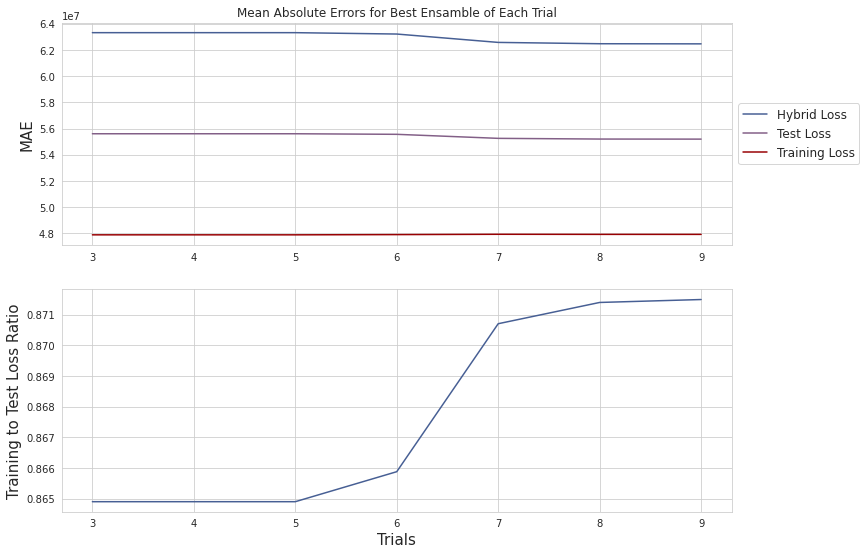

In [104]:
# assemble desired trial runs
_dict = {rfr_trials_3: 3, 
         rfr_trials_4: 4, 
         rfr_trials_5: 5, 
         rfr_trials_6: 6, 
         rfr_trials_7: 7, 
         rfr_trials_8: 8, 
         rfr_trials_9: 9
        }
# plot the results, so far
plot_metrics(_dict)

The last couple of trials did eke out a bit more performance from both parts of the hybrid loss, but not much.

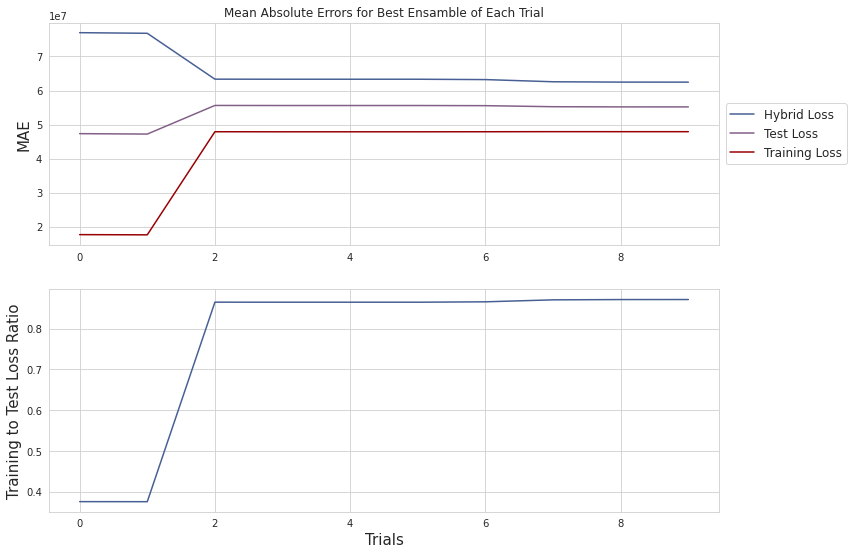

In [105]:
# assemble desired trial runs
_dict = {rfr_trials_0: 0, 
         rfr_trials_1: 1, 
         rfr_trials_2: 2, 
         rfr_trials_3: 3, 
         rfr_trials_4: 4, 
         rfr_trials_5: 5, 
         rfr_trials_6: 6, 
         rfr_trials_7: 7, 
         rfr_trials_8: 8, 
         rfr_trials_9: 9
        }
# plot the results, so far
plot_metrics(_dict)

From the perspective of the entire tuning session, not much happened after the maximum tree depth was set.<br>
RF, as it has been said before, doesn't require much tuning.

 > **Random Forest Final Evaluation**

As with the XGB analysis, I'll observe the performance on the validation set of the base model compared to best model.<br>
I will get the percent difference between the performances on the training data and validation data, also.

In [106]:
def get_cv_mae(features, target, trials=None, iteration=None, params={}):
    """Return CV average mean absolute error for given model"""
    # get fitted model
    model = get_rfr_model(
        features, target, trials=trials, iteration=iteration, params=params)
    # perform 10 fold cross validation
    cv_results = cross_val_score(model, features, target, 
                                 scoring='neg_mean_absolute_error', cv=10, n_jobs=-1)
    # convert scores to positive values
    results = cv_results * -1
    # get scores range
    results_range = (np.min(results), np.max(results))
    # get average score
    ave_result = np.mean(cv_results) * -1
        
    return ave_result

In [107]:
def get_validation_results(X, y, trials=None, iteration=None, params={}):
    """Print final validation error & percent difference between training and validation"""
    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=27)
    # get errors
    train_mae = get_cv_mae(
        X_train, y_train, trials=trials, iteration=iteration, params=params)
    test_mae = get_cv_mae(
        X_test, y_test, trials=trials, iteration=iteration, params=params)
    # get percent difference between training and test errors
    val_error = np.absolute(train_mae - test_mae) / test_mae
    
    print('Validation Error: ${:,.2f}'.format(
        test_mae) + '   Percent off from Training Error: {:,.2f}%'.format(val_error * 100))

In [108]:
# get validation results without tuning
get_validation_results(X, y)

Validation Error: $60,509,030.15   Percent off from Training Error: 21.76%


The RF base model started off with high variance, as can be observed in the high overfit score.

In [109]:
# get validation results on model with best hybrid score
get_validation_results(X, y, trials=rfr_trials_9)

Validation Error: $63,595,090.69   Percent off from Training Error: 13.22%


The variance was reduced at the cost of the model's accuracy.

The best XGB model had better performance on the validation data than the best RF model.<br>
It's error was almost 3 million dollars lower.<br>
Their overfitting ratios were nearly identical.

I began using my hybrid loss to the model optimization, because I could not rid the XGB models of extreme variance.<br>
While this method proved promising on the XGB models, it did not bear similar results for the RF models.

I believe that using the hybrid loss with an RF optimization process was not the correct strategy.<br>
Additional work should be done using the traditional MAE loss as a metric on the RF models.<br>
I believe a better result could be found.